Задача - реализация условного GANs для датасета MNIST.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np
import os 

import matplotlib
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
print(device)

%matplotlib inline

cuda:0


In [0]:
root_folder = 'FC_GAN_results'
fixed_folder = root_folder + '/Fixed_results'

if os.path.isdir(root_folder):
    !rm -r $root_folder
os.mkdir(root_folder)
os.mkdir(fixed_folder)

In [0]:
mnist_tanh = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])

In [0]:
lr = 0.0001
prior_size = 100
train_epoch = 1000
batch_size = 250
train_loader, valid_loader, test_loader = mnist(batch_size=batch_size, valid=10000, transform=mnist_tanh)
fixed_z = torch.randn((50, 100))
fixed_target = torch.randint(0,10,(50,)) # В дополнение к fixed_z создаются фиксированные лэйблы.

In [0]:
# Функция перевода меток в one-hot вектора для генератора.
def one_hot_encode(x, dim=10):
    ohe = torch.zeros((x.shape[0], dim)).to(device)
    ohe.scatter_(-1, x.view(-1, 1), 1)
    return ohe

In [0]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh(), flatten=False, last_fn=None):
        super(FullyConnected, self).__init__()
        layers = []
        self.flatten = flatten
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout(dropout))
            layers.append(activation_fn) # нам не нужен дропаут и фнкция активации в последнем слое
        else: 
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        if last_fn is not None:
            layers.append(last_fn)
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        if self.flatten:
            x = x.view(x.shape[0], -1)
        return self.model(x)

In [0]:
class Generator(nn.Module):
    # FullyConnected с увеличенным входом для меток.
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh(), flatten=False, last_fn=None):
        super(Generator, self).__init__()
        self.fc = FullyConnected(sizes, dropout, activation_fn, flatten, last_fn)

    def forward(self, x, c):        
        x = torch.cat([x, one_hot_encode(c)], 1)
        return self.fc(x)

class Classifier(nn.Module):
    # Классификатор для дискриминатора.
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh(), flatten=False, last_fn=None):
        super(Classifier, self).__init__()
        self.fc = FullyConnected(sizes, dropout, activation_fn, flatten, last_fn)

    def forward(self, x):
        return self.fc(x)

class Discriminator(nn.Module):
    # FullyConnected + Classifier
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh(), flatten=False, last_fn=None):
        super(Discriminator, self).__init__()
        self.fc = FullyConnected(sizes, dropout, activation_fn, flatten, last_fn)
        self.cla = FullyConnected([28*28, 256, 128, 10], dropout=0.3, activation_fn=nn.LeakyReLU(0.2), flatten=True)

    def forward(self, x):
        y = self.fc(x)
        logits = self.cla(x)
        return y, logits # Возвращает бинарную метку true/fake и логиты.

In [0]:
G = Generator([prior_size+10, 256, 512, 1024, 28*28], activation_fn=nn.LeakyReLU(0.2), last_fn=nn.Tanh())
D = Discriminator([28*28, 1024, 512, 256, 1], dropout=0.3, activation_fn=nn.LeakyReLU(0.2), flatten=True)
G.to(device)
D.to(device)

G_optimizer = optim.Adam(G.parameters(), lr=lr)
D_optimizer = optim.Adam(D.parameters(), lr=lr)

In [0]:
train_log = {'G': [], 'D': []}
test_log = {'G': [], 'D': []}

In [0]:
batch_zeros = torch.zeros((batch_size, 1)).to(device)
batch_ones = torch.ones((batch_size, 1)).to(device)

In [0]:
def train(epoch, G, D, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        # train D
        data = data.to(device)
        target = target.to(device)
        D.zero_grad()
        G.zero_grad()
        z = torch.randn((batch_size, prior_size)).to(device)
        fake_pred, fake_logits = D(G(z, target))
        true_pred, true_logits = D(data)
        
        fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
        true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones)
        
        # К функции потерь дискриминатора добавлена ошибка классификации (только по истинным образцам).
        D_loss = 0.5*(fake_loss + true_loss) + F.cross_entropy(true_logits, target)
        
        D_loss.backward()
        D_optimizer.step()
        
        # train G
        D.zero_grad()
        G.zero_grad()
        z = torch.randn((batch_size, prior_size)).to(device)
        fake_pred, fake_logits = D(G(z, target))
        
        # К потерям генератора добавлена ошибка классификации по сгенерированным данным.
        G_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_ones) + F.cross_entropy(fake_logits, target)
        
        G_loss.backward()
        
        G_optimizer.step()
            
        if batch_idx % 100 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = 'G: {:.4f}, D: {:.4f}'.format(G_loss.item(), D_loss.item())
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = 'G: {:.4f}, D: {:.4f}'.format(G_loss.item(), D_loss.item())
        print(line + losses)
        log['G'].append(G_loss.item())
        log['D'].append(D_loss.item())

In [0]:
def test(G, D, loader, epoch, log=None):
    test_size = len(loader)
    G_loss = 0.
    D_loss = 0.
    test_loss = {'G': 0., 'D': 0.}
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            target = target.to(device)
            z = torch.randn((batch_size, prior_size)).to(device)
            fake_pred, fake_logits = D(G(z, target))
            true_pred, true_logits = D(data)
        
            fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros).item() #+ F.cross_entropy(fake_logits, target).item())
            true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones).item() #+ F.cross_entropy(true_logits, target).item())
            
            D_loss += 0.5*(fake_loss + true_loss) + F.cross_entropy(true_logits, target).item()
            G_loss += F.binary_cross_entropy_with_logits(fake_pred, batch_ones).item() + F.cross_entropy(fake_logits, target).item()
    
    G_loss /= test_size
    D_loss /= test_size

    fixed_gen = G(fixed_z.to(device), fixed_target.to(device)).cpu().data.numpy().reshape(50, 1, 28, 28)
    plot_mnist(fixed_gen, (5, 10), True, fixed_folder + '/%03d.png' % epoch)
    report = 'Test losses. G: {:.4f}, D: {:.4f}'.format(G_loss, D_loss)
    print(report)
    if log is not None:
        log['G'].append(G_loss)
        log['D'].append(D_loss)

Train Epoch: 1 [0/50000 (0%)]	Losses G: 2.9709, D: 2.9966
Train Epoch: 1 [25000/50000 (50%)]	Losses G: 3.8200, D: 1.4052
Train Epoch: 1 [50000/50000 (100%)]	Losses G: 3.0858, D: 1.4278


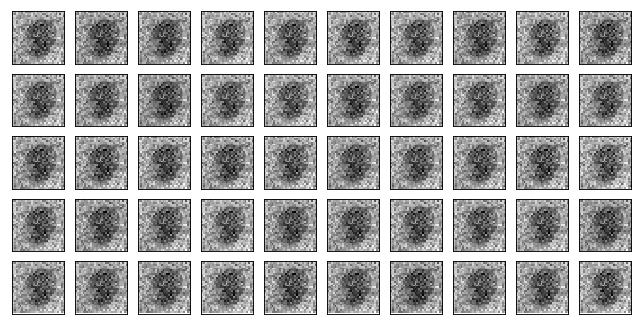

Test losses. G: 2.7104, D: 1.2303
Train Epoch: 2 [0/50000 (0%)]	Losses G: 3.0621, D: 1.4062
Train Epoch: 2 [25000/50000 (50%)]	Losses G: 2.9318, D: 1.4409
Train Epoch: 2 [50000/50000 (100%)]	Losses G: 5.9638, D: 0.7137


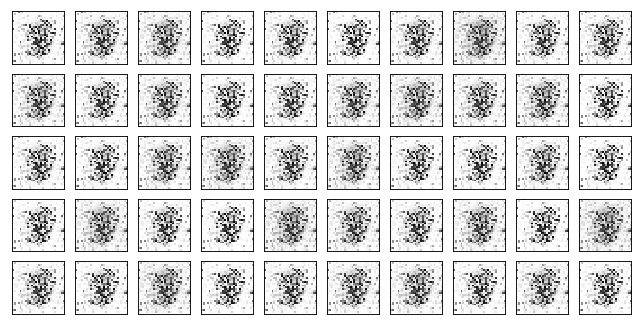

Test losses. G: 4.0610, D: 0.6288
Train Epoch: 3 [0/50000 (0%)]	Losses G: 5.7410, D: 0.6756
Train Epoch: 3 [25000/50000 (50%)]	Losses G: 4.5248, D: 0.8199
Train Epoch: 3 [50000/50000 (100%)]	Losses G: 4.9913, D: 0.9165


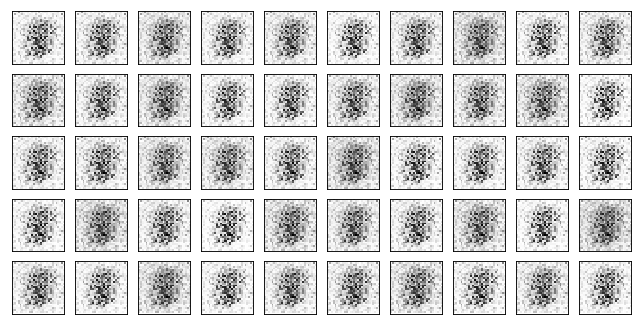

Test losses. G: 3.7089, D: 0.8298
Train Epoch: 4 [0/50000 (0%)]	Losses G: 5.0056, D: 0.9238
Train Epoch: 4 [25000/50000 (50%)]	Losses G: 4.5467, D: 0.9258
Train Epoch: 4 [50000/50000 (100%)]	Losses G: 3.3230, D: 1.0066


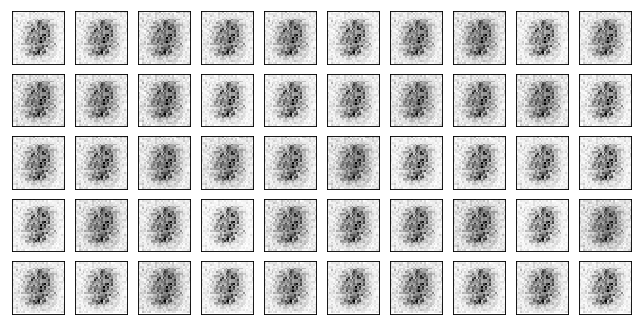

Test losses. G: 3.1459, D: 0.8841
Train Epoch: 5 [0/50000 (0%)]	Losses G: 3.3073, D: 1.1014
Train Epoch: 5 [25000/50000 (50%)]	Losses G: 3.7325, D: 0.7509
Train Epoch: 5 [50000/50000 (100%)]	Losses G: 3.5066, D: 0.7519


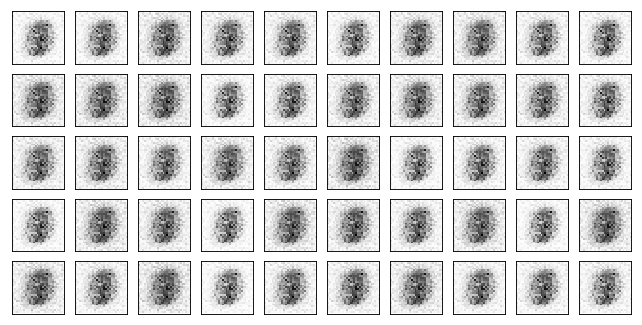

Test losses. G: 3.2855, D: 0.7290
Train Epoch: 6 [0/50000 (0%)]	Losses G: 3.4054, D: 0.9182
Train Epoch: 6 [25000/50000 (50%)]	Losses G: 4.1772, D: 0.6935
Train Epoch: 6 [50000/50000 (100%)]	Losses G: 3.9888, D: 1.0890


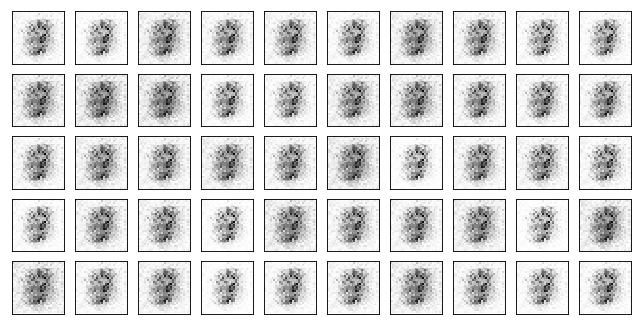

Test losses. G: 2.9236, D: 1.0092
Train Epoch: 7 [0/50000 (0%)]	Losses G: 3.7183, D: 1.1748
Train Epoch: 7 [25000/50000 (50%)]	Losses G: 3.5233, D: 0.7482
Train Epoch: 7 [50000/50000 (100%)]	Losses G: 4.9241, D: 0.4396


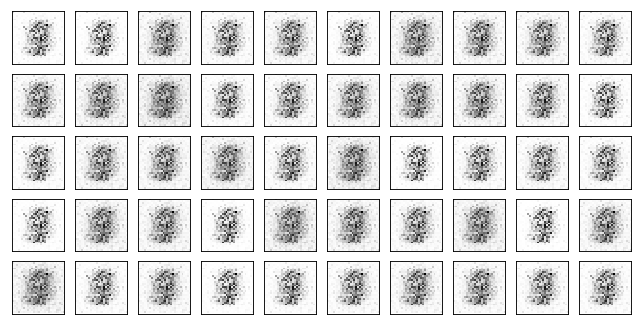

Test losses. G: 4.7618, D: 0.3242
Train Epoch: 8 [0/50000 (0%)]	Losses G: 5.1686, D: 0.3554
Train Epoch: 8 [25000/50000 (50%)]	Losses G: 5.1391, D: 0.4151
Train Epoch: 8 [50000/50000 (100%)]	Losses G: 6.0081, D: 0.3414


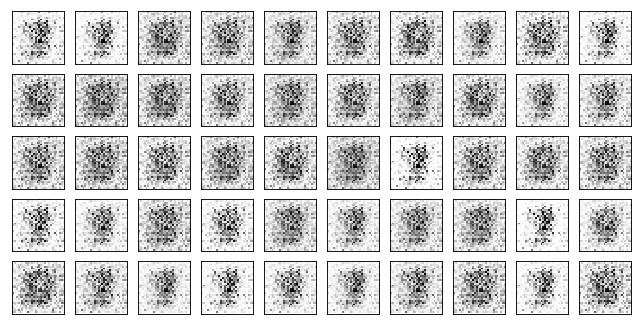

Test losses. G: 4.4346, D: 0.3408
Train Epoch: 9 [0/50000 (0%)]	Losses G: 5.9093, D: 0.5140
Train Epoch: 9 [25000/50000 (50%)]	Losses G: 4.3808, D: 0.5251
Train Epoch: 9 [50000/50000 (100%)]	Losses G: 3.3200, D: 0.5616


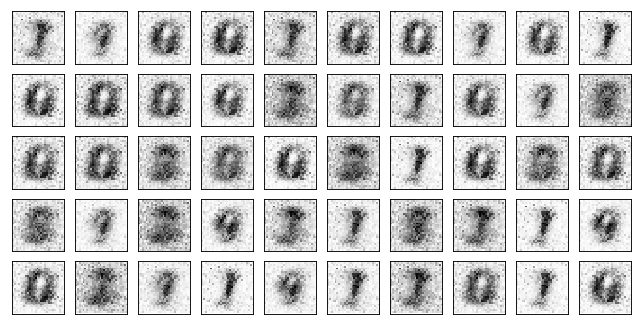

Test losses. G: 2.9109, D: 0.3667
Train Epoch: 10 [0/50000 (0%)]	Losses G: 3.2522, D: 0.5230
Train Epoch: 10 [25000/50000 (50%)]	Losses G: 2.7925, D: 0.7089
Train Epoch: 10 [50000/50000 (100%)]	Losses G: 4.4349, D: 0.4393


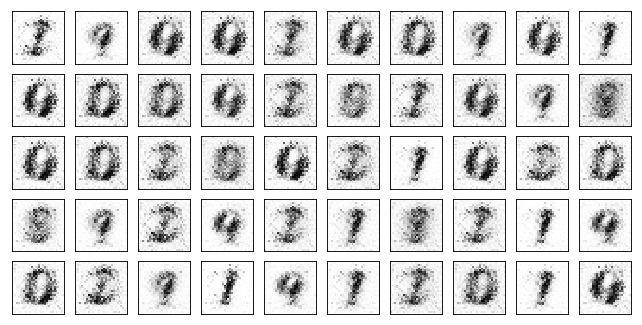

Test losses. G: 3.6990, D: 0.2760
Train Epoch: 11 [0/50000 (0%)]	Losses G: 4.8017, D: 0.4069
Train Epoch: 11 [25000/50000 (50%)]	Losses G: 4.7982, D: 0.4340
Train Epoch: 11 [50000/50000 (100%)]	Losses G: 3.3766, D: 0.6940


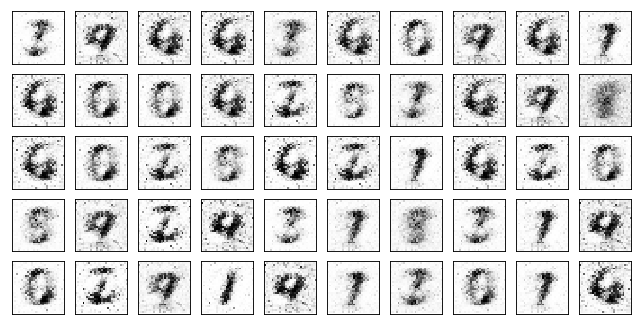

Test losses. G: 2.7929, D: 0.4184
Train Epoch: 12 [0/50000 (0%)]	Losses G: 3.2940, D: 0.5823
Train Epoch: 12 [25000/50000 (50%)]	Losses G: 4.4236, D: 0.4102
Train Epoch: 12 [50000/50000 (100%)]	Losses G: 4.5464, D: 0.2768


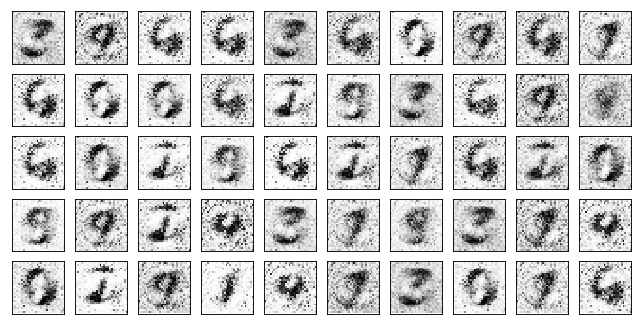

Test losses. G: 3.7697, D: 0.2390
Train Epoch: 13 [0/50000 (0%)]	Losses G: 4.8436, D: 0.3205
Train Epoch: 13 [25000/50000 (50%)]	Losses G: 5.0514, D: 0.4892
Train Epoch: 13 [50000/50000 (100%)]	Losses G: 4.3836, D: 0.3501


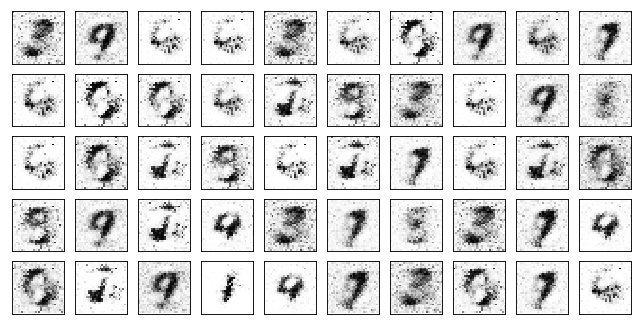

Test losses. G: 3.7731, D: 0.2160
Train Epoch: 14 [0/50000 (0%)]	Losses G: 4.4875, D: 0.3303
Train Epoch: 14 [25000/50000 (50%)]	Losses G: 4.9478, D: 0.3504
Train Epoch: 14 [50000/50000 (100%)]	Losses G: 4.1921, D: 0.3420


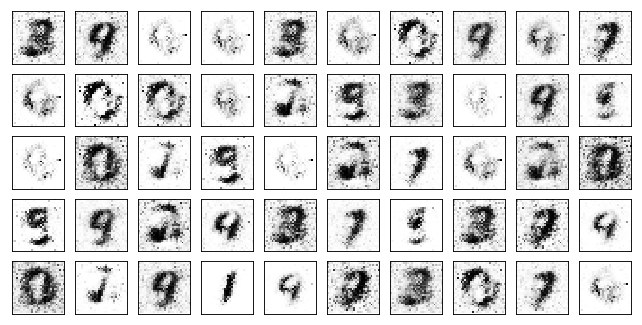

Test losses. G: 3.8642, D: 0.3092
Train Epoch: 15 [0/50000 (0%)]	Losses G: 4.1181, D: 0.4955
Train Epoch: 15 [25000/50000 (50%)]	Losses G: 4.8626, D: 0.4476
Train Epoch: 15 [50000/50000 (100%)]	Losses G: 4.2115, D: 0.3619


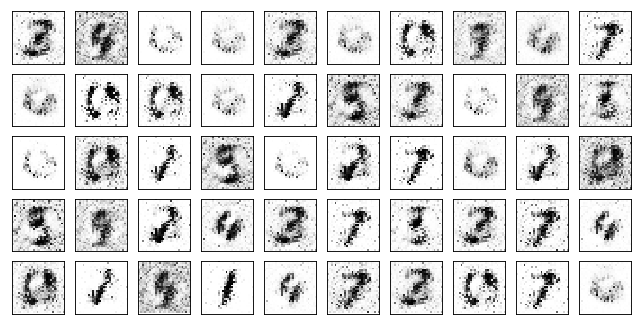

Test losses. G: 3.8800, D: 0.1972
Train Epoch: 16 [0/50000 (0%)]	Losses G: 4.7858, D: 0.2511
Train Epoch: 16 [25000/50000 (50%)]	Losses G: 5.9750, D: 0.2805
Train Epoch: 16 [50000/50000 (100%)]	Losses G: 4.6116, D: 0.3720


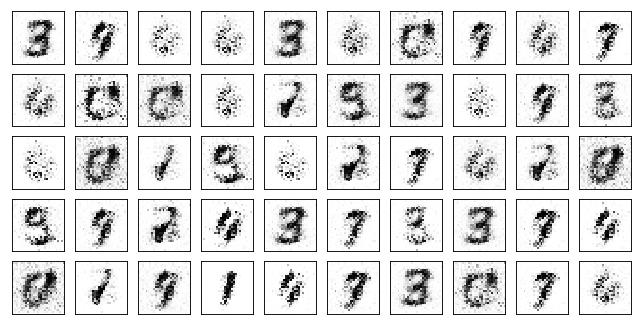

Test losses. G: 4.2750, D: 0.2025
Train Epoch: 17 [0/50000 (0%)]	Losses G: 5.1179, D: 0.3047
Train Epoch: 17 [25000/50000 (50%)]	Losses G: 5.6273, D: 0.2812
Train Epoch: 17 [50000/50000 (100%)]	Losses G: 4.8249, D: 0.2943


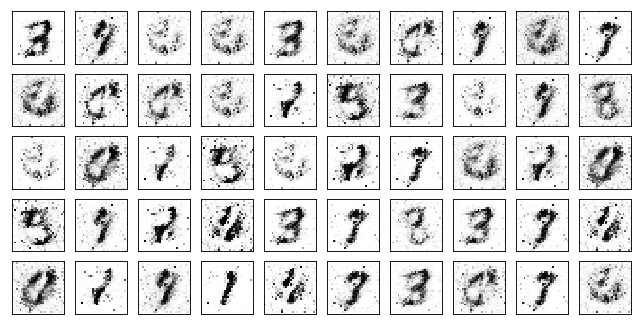

Test losses. G: 4.3978, D: 0.1733
Train Epoch: 18 [0/50000 (0%)]	Losses G: 5.0377, D: 0.2244
Train Epoch: 18 [25000/50000 (50%)]	Losses G: 5.1721, D: 0.3758
Train Epoch: 18 [50000/50000 (100%)]	Losses G: 6.1426, D: 0.2467


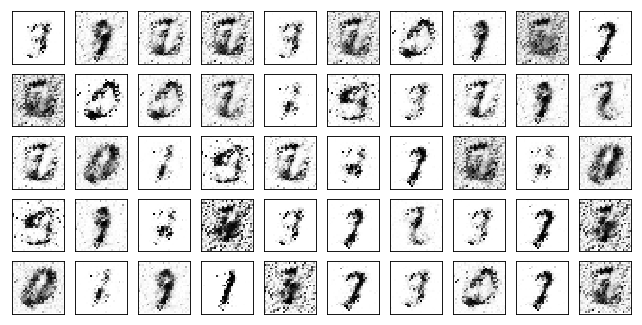

Test losses. G: 5.3653, D: 0.1774
Train Epoch: 19 [0/50000 (0%)]	Losses G: 5.8199, D: 0.2497
Train Epoch: 19 [25000/50000 (50%)]	Losses G: 5.6977, D: 0.2948
Train Epoch: 19 [50000/50000 (100%)]	Losses G: 5.8168, D: 0.2957


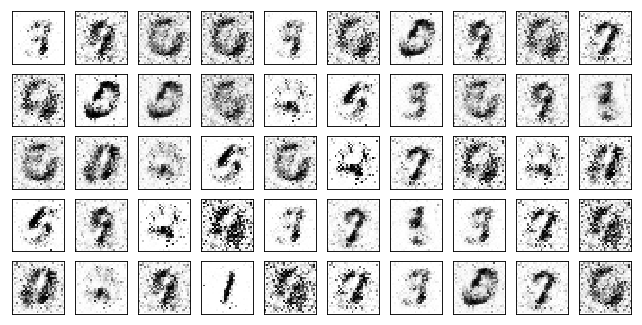

Test losses. G: 4.9937, D: 0.1900
Train Epoch: 20 [0/50000 (0%)]	Losses G: 6.6353, D: 0.2476
Train Epoch: 20 [25000/50000 (50%)]	Losses G: 5.3612, D: 0.1862
Train Epoch: 20 [50000/50000 (100%)]	Losses G: 4.5739, D: 0.2868


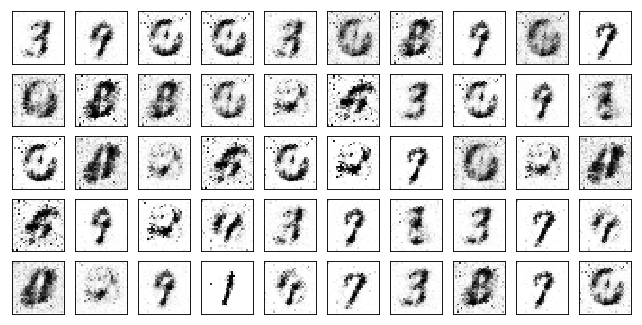

Test losses. G: 4.2794, D: 0.1892
Train Epoch: 21 [0/50000 (0%)]	Losses G: 4.3273, D: 0.2844
Train Epoch: 21 [25000/50000 (50%)]	Losses G: 5.0692, D: 0.2301
Train Epoch: 21 [50000/50000 (100%)]	Losses G: 5.0540, D: 0.3081


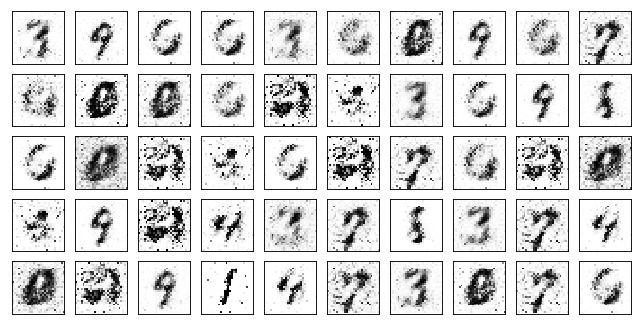

Test losses. G: 4.4926, D: 0.1701
Train Epoch: 22 [0/50000 (0%)]	Losses G: 5.2395, D: 0.3319
Train Epoch: 22 [25000/50000 (50%)]	Losses G: 4.4434, D: 0.3859
Train Epoch: 22 [50000/50000 (100%)]	Losses G: 4.5350, D: 0.3526


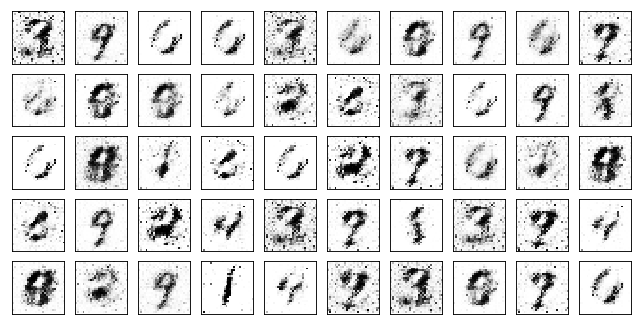

Test losses. G: 3.6160, D: 0.1866
Train Epoch: 23 [0/50000 (0%)]	Losses G: 4.3204, D: 0.3344
Train Epoch: 23 [25000/50000 (50%)]	Losses G: 4.8054, D: 0.3067
Train Epoch: 23 [50000/50000 (100%)]	Losses G: 5.3924, D: 0.2576


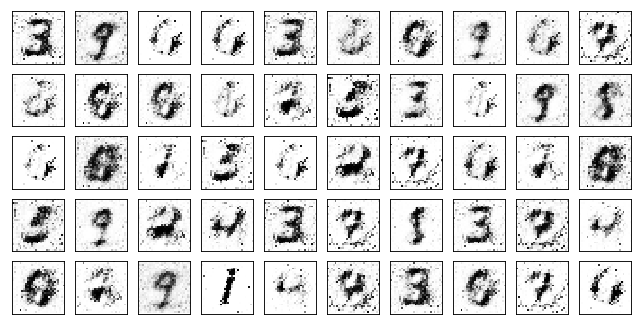

Test losses. G: 4.7398, D: 0.1898
Train Epoch: 24 [0/50000 (0%)]	Losses G: 3.9769, D: 0.2611
Train Epoch: 24 [25000/50000 (50%)]	Losses G: 5.2013, D: 0.2028
Train Epoch: 24 [50000/50000 (100%)]	Losses G: 5.1511, D: 0.2809


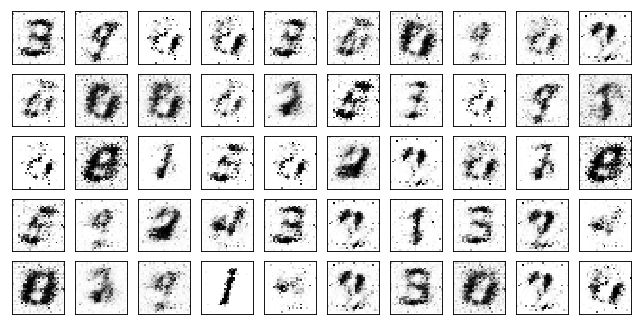

Test losses. G: 4.3643, D: 0.1556
Train Epoch: 25 [0/50000 (0%)]	Losses G: 5.4996, D: 0.3135
Train Epoch: 25 [25000/50000 (50%)]	Losses G: 5.0788, D: 0.2665
Train Epoch: 25 [50000/50000 (100%)]	Losses G: 4.4019, D: 0.3063


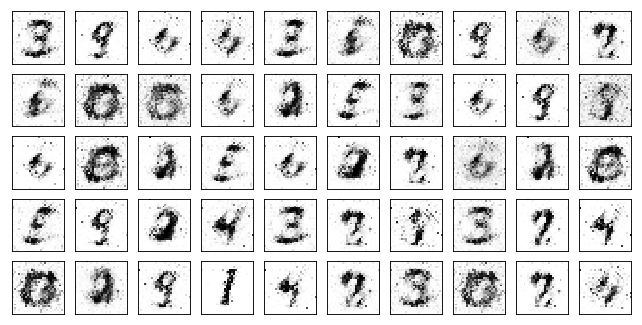

Test losses. G: 3.5772, D: 0.1759
Train Epoch: 26 [0/50000 (0%)]	Losses G: 6.1140, D: 0.2674
Train Epoch: 26 [25000/50000 (50%)]	Losses G: 4.9977, D: 0.2573
Train Epoch: 26 [50000/50000 (100%)]	Losses G: 4.7966, D: 0.2001


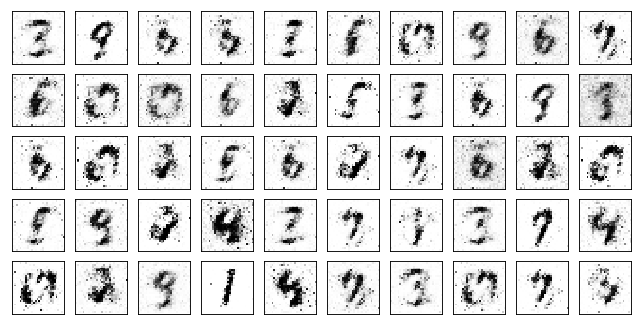

Test losses. G: 4.2694, D: 0.1676
Train Epoch: 27 [0/50000 (0%)]	Losses G: 5.9144, D: 0.2281
Train Epoch: 27 [25000/50000 (50%)]	Losses G: 4.7142, D: 0.2353
Train Epoch: 27 [50000/50000 (100%)]	Losses G: 4.8306, D: 0.3025


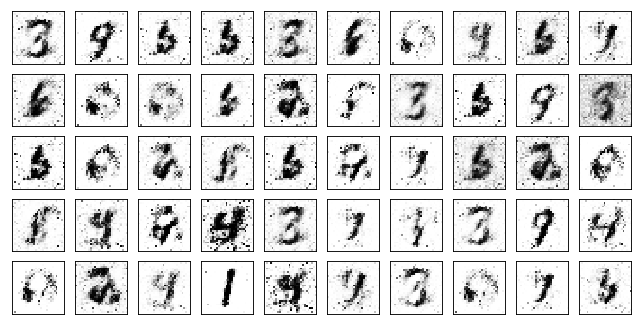

Test losses. G: 4.1360, D: 0.1701
Train Epoch: 28 [0/50000 (0%)]	Losses G: 5.1563, D: 0.2698
Train Epoch: 28 [25000/50000 (50%)]	Losses G: 4.2040, D: 0.2094
Train Epoch: 28 [50000/50000 (100%)]	Losses G: 4.8723, D: 0.2365


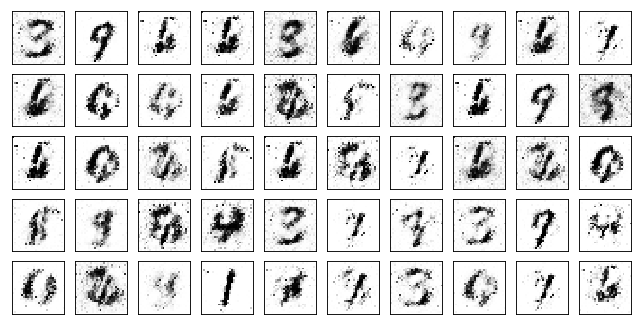

Test losses. G: 4.3041, D: 0.1607
Train Epoch: 29 [0/50000 (0%)]	Losses G: 5.0916, D: 0.2974
Train Epoch: 29 [25000/50000 (50%)]	Losses G: 4.8389, D: 0.2308
Train Epoch: 29 [50000/50000 (100%)]	Losses G: 4.5995, D: 0.3497


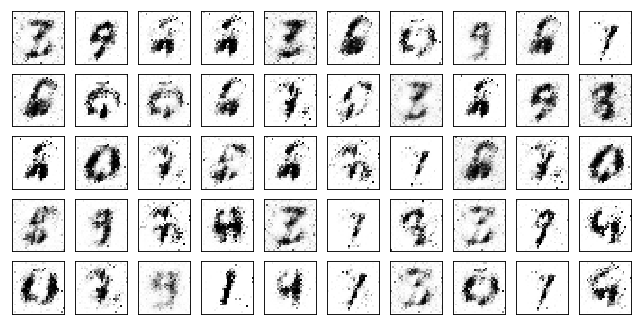

Test losses. G: 4.1497, D: 0.1894
Train Epoch: 30 [0/50000 (0%)]	Losses G: 4.6839, D: 0.3290
Train Epoch: 30 [25000/50000 (50%)]	Losses G: 4.7738, D: 0.2655
Train Epoch: 30 [50000/50000 (100%)]	Losses G: 4.7634, D: 0.2352


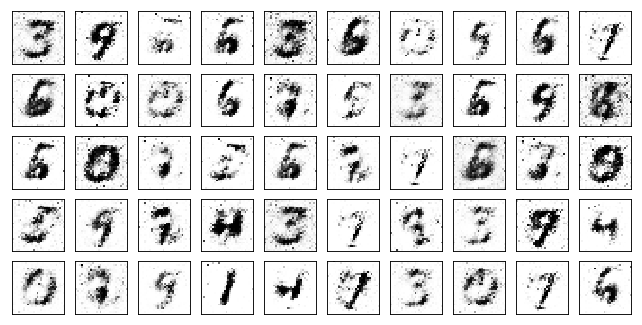

Test losses. G: 4.2876, D: 0.1562
Train Epoch: 31 [0/50000 (0%)]	Losses G: 5.1207, D: 0.2984
Train Epoch: 31 [25000/50000 (50%)]	Losses G: 4.0489, D: 0.3366
Train Epoch: 31 [50000/50000 (100%)]	Losses G: 4.0635, D: 0.2848


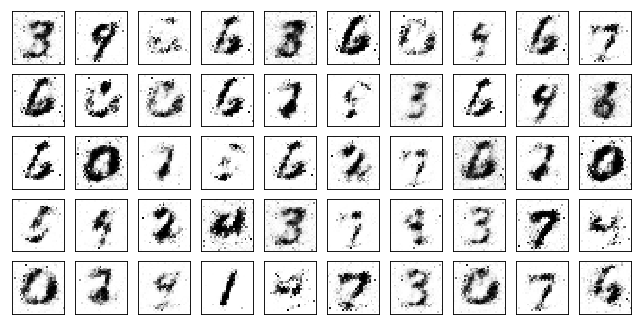

Test losses. G: 3.7048, D: 0.1704
Train Epoch: 32 [0/50000 (0%)]	Losses G: 3.7374, D: 0.2532
Train Epoch: 32 [25000/50000 (50%)]	Losses G: 5.0203, D: 0.2194
Train Epoch: 32 [50000/50000 (100%)]	Losses G: 4.6654, D: 0.2346


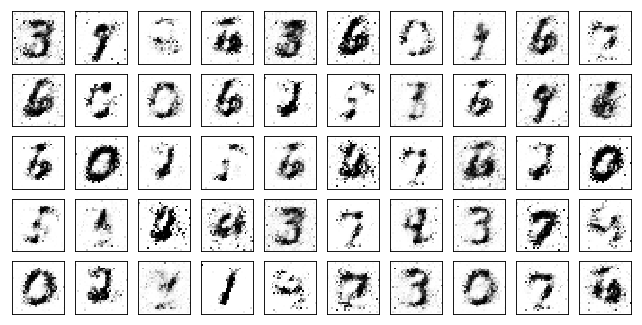

Test losses. G: 4.2616, D: 0.1712
Train Epoch: 33 [0/50000 (0%)]	Losses G: 4.4442, D: 0.2865
Train Epoch: 33 [25000/50000 (50%)]	Losses G: 5.1015, D: 0.2669
Train Epoch: 33 [50000/50000 (100%)]	Losses G: 5.2592, D: 0.2201


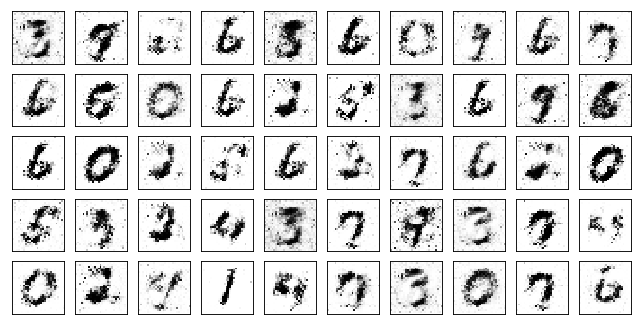

Test losses. G: 4.4805, D: 0.1560
Train Epoch: 34 [0/50000 (0%)]	Losses G: 5.1444, D: 0.2211
Train Epoch: 34 [25000/50000 (50%)]	Losses G: 4.7733, D: 0.2915
Train Epoch: 34 [50000/50000 (100%)]	Losses G: 3.5391, D: 0.2012


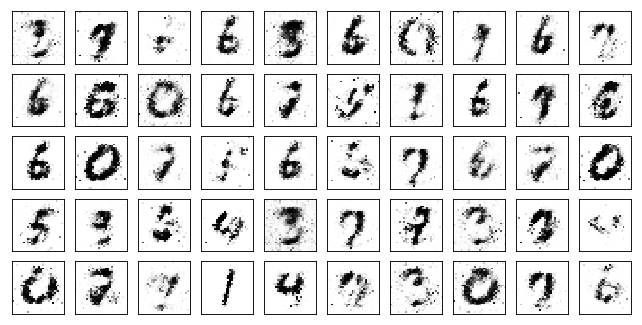

Test losses. G: 3.3042, D: 0.1621
Train Epoch: 35 [0/50000 (0%)]	Losses G: 4.1570, D: 0.1875
Train Epoch: 35 [25000/50000 (50%)]	Losses G: 4.0818, D: 0.2847
Train Epoch: 35 [50000/50000 (100%)]	Losses G: 3.8484, D: 0.2475


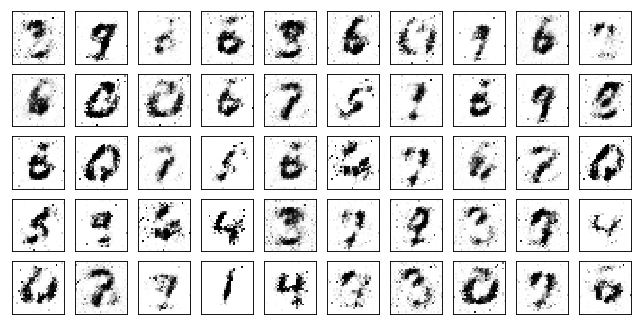

Test losses. G: 3.5237, D: 0.1569
Train Epoch: 36 [0/50000 (0%)]	Losses G: 3.6921, D: 0.1907
Train Epoch: 36 [25000/50000 (50%)]	Losses G: 4.3841, D: 0.2012
Train Epoch: 36 [50000/50000 (100%)]	Losses G: 4.4076, D: 0.1708


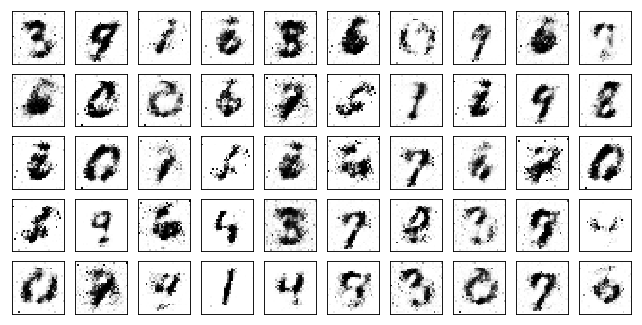

Test losses. G: 3.7442, D: 0.1469
Train Epoch: 37 [0/50000 (0%)]	Losses G: 4.4941, D: 0.1996
Train Epoch: 37 [25000/50000 (50%)]	Losses G: 4.4269, D: 0.2215
Train Epoch: 37 [50000/50000 (100%)]	Losses G: 3.6510, D: 0.3348


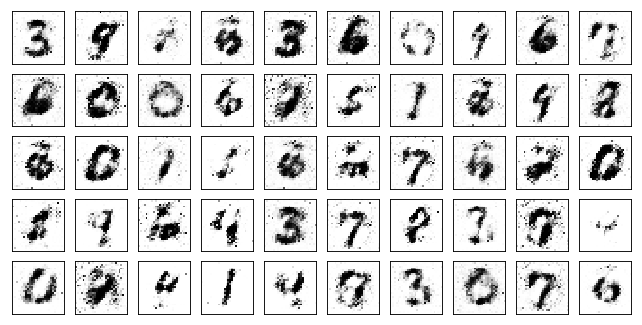

Test losses. G: 3.2184, D: 0.1970
Train Epoch: 38 [0/50000 (0%)]	Losses G: 3.7318, D: 0.3055
Train Epoch: 38 [25000/50000 (50%)]	Losses G: 3.4279, D: 0.2922
Train Epoch: 38 [50000/50000 (100%)]	Losses G: 3.7160, D: 0.2828


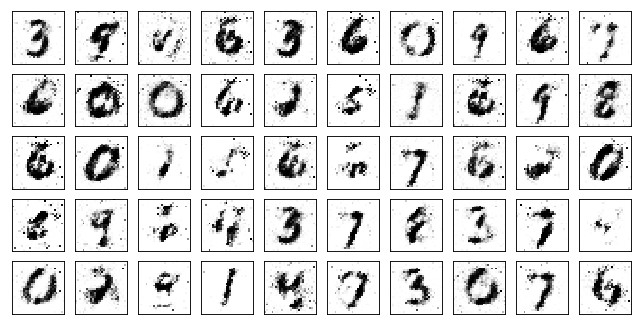

Test losses. G: 3.4934, D: 0.1684
Train Epoch: 39 [0/50000 (0%)]	Losses G: 4.1193, D: 0.2175
Train Epoch: 39 [25000/50000 (50%)]	Losses G: 3.5042, D: 0.2889
Train Epoch: 39 [50000/50000 (100%)]	Losses G: 3.6040, D: 0.3046


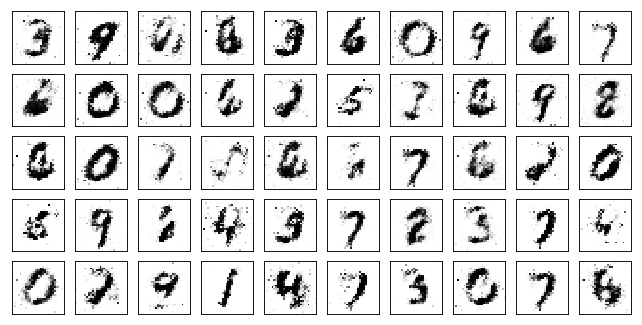

Test losses. G: 3.1677, D: 0.1734
Train Epoch: 40 [0/50000 (0%)]	Losses G: 3.9875, D: 0.2587
Train Epoch: 40 [25000/50000 (50%)]	Losses G: 3.7393, D: 0.2583
Train Epoch: 40 [50000/50000 (100%)]	Losses G: 3.7360, D: 0.3162


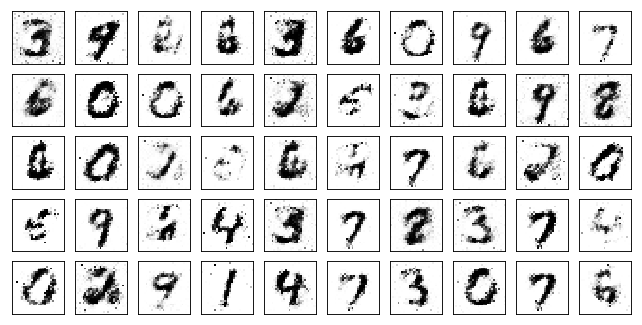

Test losses. G: 3.4160, D: 0.2531
Train Epoch: 41 [0/50000 (0%)]	Losses G: 3.4935, D: 0.3023
Train Epoch: 41 [25000/50000 (50%)]	Losses G: 3.8592, D: 0.3340
Train Epoch: 41 [50000/50000 (100%)]	Losses G: 4.1107, D: 0.3005


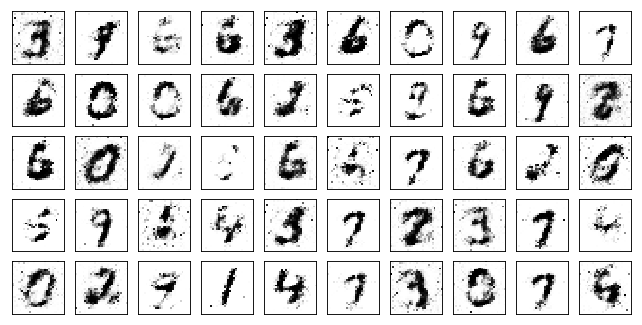

Test losses. G: 3.6179, D: 0.2542
Train Epoch: 42 [0/50000 (0%)]	Losses G: 3.7712, D: 0.3166
Train Epoch: 42 [25000/50000 (50%)]	Losses G: 2.9169, D: 0.2498
Train Epoch: 42 [50000/50000 (100%)]	Losses G: 3.7699, D: 0.2030


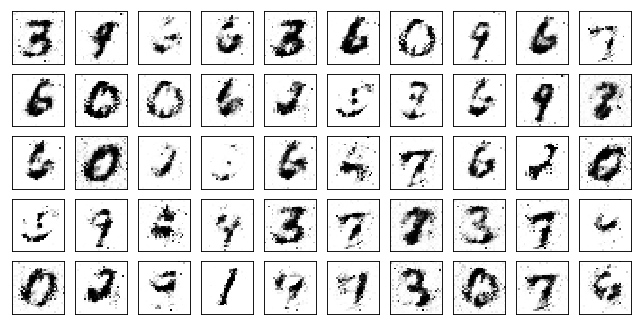

Test losses. G: 3.5079, D: 0.1642
Train Epoch: 43 [0/50000 (0%)]	Losses G: 3.6777, D: 0.2059
Train Epoch: 43 [25000/50000 (50%)]	Losses G: 4.3867, D: 0.2143
Train Epoch: 43 [50000/50000 (100%)]	Losses G: 3.7154, D: 0.2167


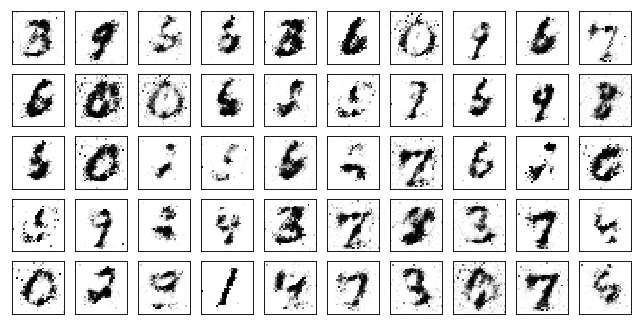

Test losses. G: 3.3963, D: 0.1616
Train Epoch: 44 [0/50000 (0%)]	Losses G: 3.6717, D: 0.2504
Train Epoch: 44 [25000/50000 (50%)]	Losses G: 3.6184, D: 0.2591
Train Epoch: 44 [50000/50000 (100%)]	Losses G: 3.5317, D: 0.2649


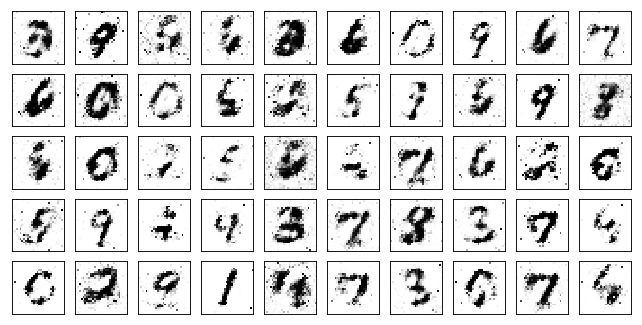

Test losses. G: 3.3984, D: 0.1843
Train Epoch: 45 [0/50000 (0%)]	Losses G: 3.4873, D: 0.2506
Train Epoch: 45 [25000/50000 (50%)]	Losses G: 2.5741, D: 0.3069
Train Epoch: 45 [50000/50000 (100%)]	Losses G: 3.4230, D: 0.3034


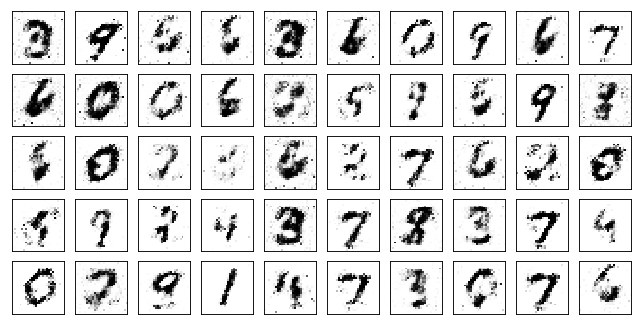

Test losses. G: 3.1685, D: 0.2329
Train Epoch: 46 [0/50000 (0%)]	Losses G: 3.5598, D: 0.3086
Train Epoch: 46 [25000/50000 (50%)]	Losses G: 3.3282, D: 0.2170
Train Epoch: 46 [50000/50000 (100%)]	Losses G: 4.3995, D: 0.2142


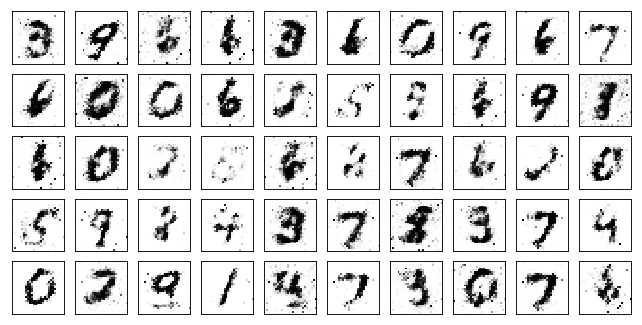

Test losses. G: 4.0665, D: 0.1994
Train Epoch: 47 [0/50000 (0%)]	Losses G: 3.9295, D: 0.2849
Train Epoch: 47 [25000/50000 (50%)]	Losses G: 3.4857, D: 0.2130
Train Epoch: 47 [50000/50000 (100%)]	Losses G: 3.8085, D: 0.3401


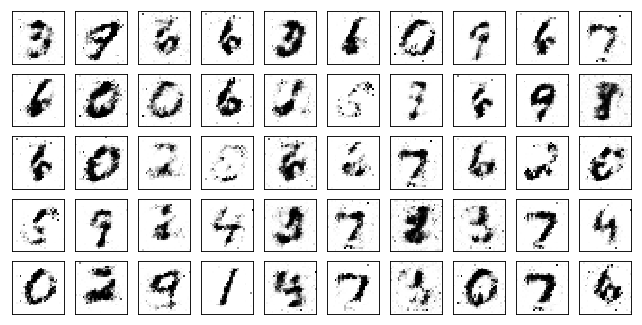

Test losses. G: 3.4440, D: 0.2478
Train Epoch: 48 [0/50000 (0%)]	Losses G: 3.5250, D: 0.3632
Train Epoch: 48 [25000/50000 (50%)]	Losses G: 3.1993, D: 0.3464
Train Epoch: 48 [50000/50000 (100%)]	Losses G: 3.1888, D: 0.2738


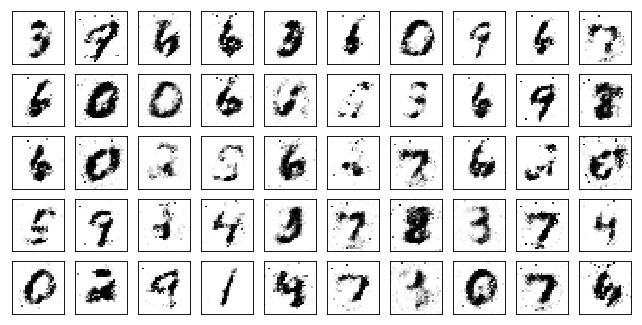

Test losses. G: 3.0345, D: 0.2108
Train Epoch: 49 [0/50000 (0%)]	Losses G: 2.8299, D: 0.2801
Train Epoch: 49 [25000/50000 (50%)]	Losses G: 3.6870, D: 0.3243
Train Epoch: 49 [50000/50000 (100%)]	Losses G: 2.9444, D: 0.3001


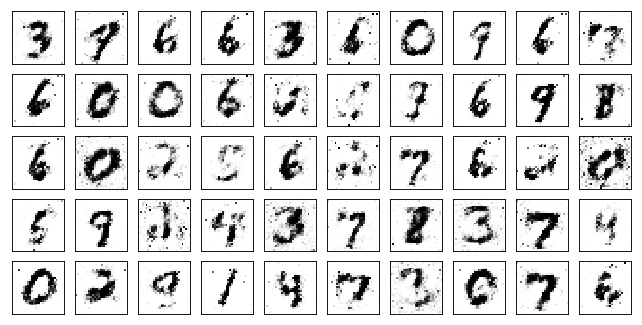

Test losses. G: 2.9008, D: 0.2481
Train Epoch: 50 [0/50000 (0%)]	Losses G: 3.1159, D: 0.3469
Train Epoch: 50 [25000/50000 (50%)]	Losses G: 2.6882, D: 0.2515
Train Epoch: 50 [50000/50000 (100%)]	Losses G: 3.7427, D: 0.3527


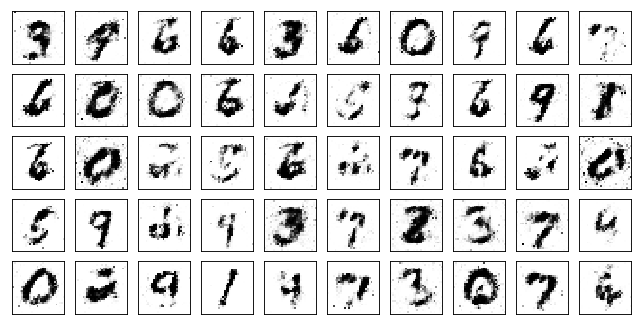

Test losses. G: 3.5321, D: 0.2014
Train Epoch: 51 [0/50000 (0%)]	Losses G: 3.7928, D: 0.2330
Train Epoch: 51 [25000/50000 (50%)]	Losses G: 2.8375, D: 0.2769
Train Epoch: 51 [50000/50000 (100%)]	Losses G: 3.8090, D: 0.3426


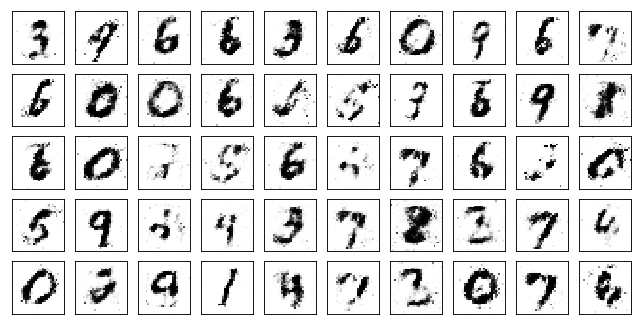

Test losses. G: 3.4124, D: 0.3078
Train Epoch: 52 [0/50000 (0%)]	Losses G: 3.1528, D: 0.4209
Train Epoch: 52 [25000/50000 (50%)]	Losses G: 3.0485, D: 0.3887
Train Epoch: 52 [50000/50000 (100%)]	Losses G: 2.8817, D: 0.3315


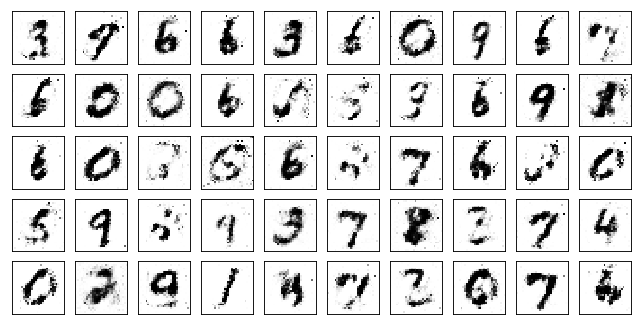

Test losses. G: 2.8365, D: 0.2711
Train Epoch: 53 [0/50000 (0%)]	Losses G: 2.7232, D: 0.3378
Train Epoch: 53 [25000/50000 (50%)]	Losses G: 3.2743, D: 0.2461
Train Epoch: 53 [50000/50000 (100%)]	Losses G: 3.4300, D: 0.3455


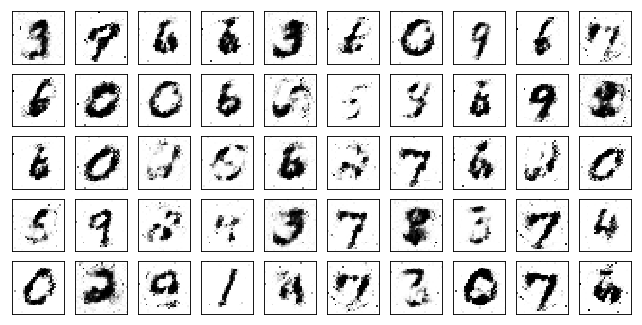

Test losses. G: 3.0275, D: 0.2305
Train Epoch: 54 [0/50000 (0%)]	Losses G: 3.1188, D: 0.3075
Train Epoch: 54 [25000/50000 (50%)]	Losses G: 2.5488, D: 0.4707
Train Epoch: 54 [50000/50000 (100%)]	Losses G: 3.5997, D: 0.3811


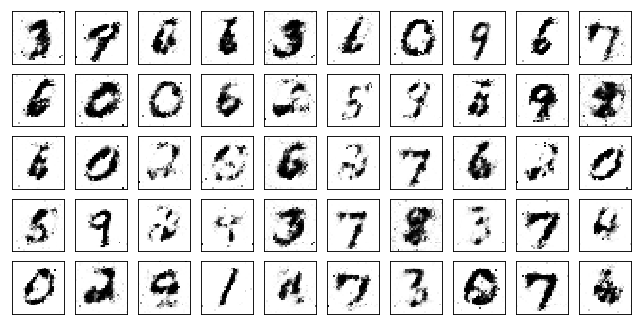

Test losses. G: 3.3994, D: 0.2979
Train Epoch: 55 [0/50000 (0%)]	Losses G: 3.3060, D: 0.4355
Train Epoch: 55 [25000/50000 (50%)]	Losses G: 2.1384, D: 0.3656
Train Epoch: 55 [50000/50000 (100%)]	Losses G: 2.7087, D: 0.3562


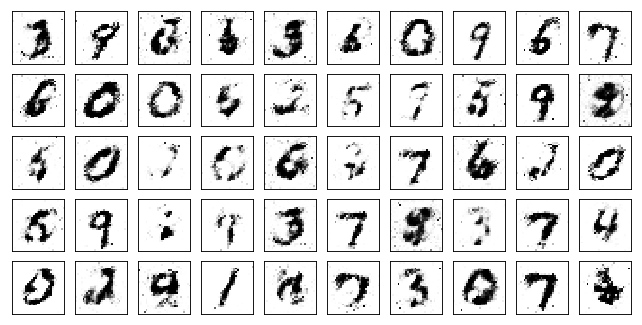

Test losses. G: 2.5542, D: 0.3114
Train Epoch: 56 [0/50000 (0%)]	Losses G: 2.5709, D: 0.3188
Train Epoch: 56 [25000/50000 (50%)]	Losses G: 2.8601, D: 0.3989
Train Epoch: 56 [50000/50000 (100%)]	Losses G: 2.2191, D: 0.3767


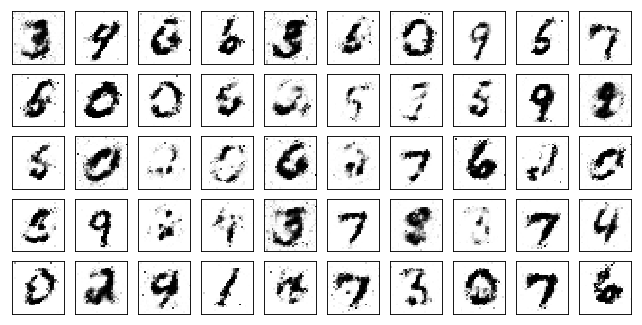

Test losses. G: 2.1531, D: 0.3068
Train Epoch: 57 [0/50000 (0%)]	Losses G: 2.4795, D: 0.4840
Train Epoch: 57 [25000/50000 (50%)]	Losses G: 2.9894, D: 0.3134
Train Epoch: 57 [50000/50000 (100%)]	Losses G: 2.5883, D: 0.3628


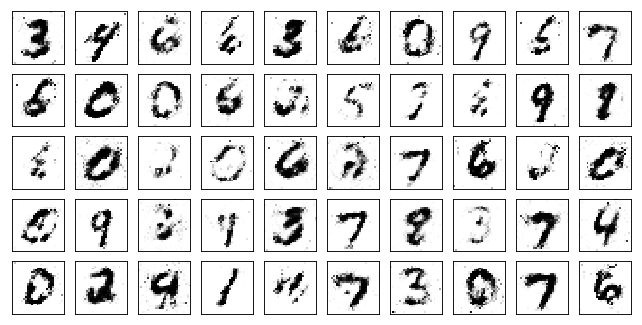

Test losses. G: 2.5192, D: 0.3039
Train Epoch: 58 [0/50000 (0%)]	Losses G: 2.4721, D: 0.3811
Train Epoch: 58 [25000/50000 (50%)]	Losses G: 2.1999, D: 0.4474
Train Epoch: 58 [50000/50000 (100%)]	Losses G: 2.8197, D: 0.4335


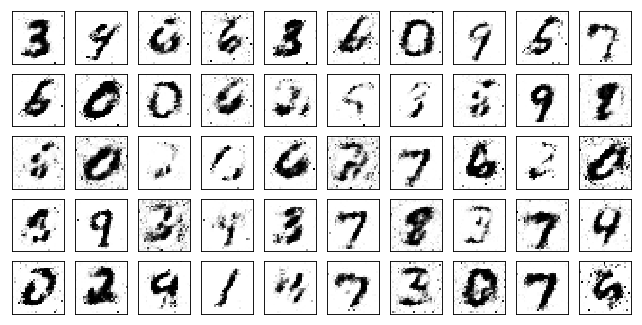

Test losses. G: 2.7415, D: 0.3414
Train Epoch: 59 [0/50000 (0%)]	Losses G: 2.4358, D: 0.4643
Train Epoch: 59 [25000/50000 (50%)]	Losses G: 2.3168, D: 0.4230
Train Epoch: 59 [50000/50000 (100%)]	Losses G: 2.7431, D: 0.3503


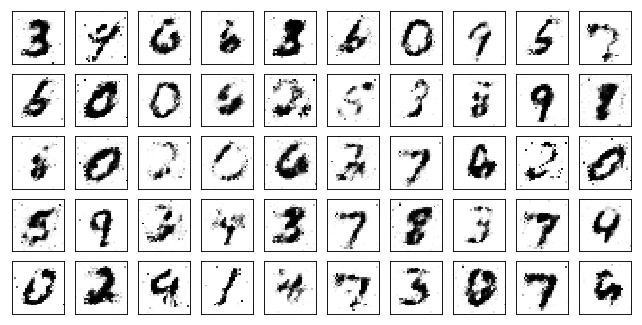

Test losses. G: 2.6253, D: 0.2394
Train Epoch: 60 [0/50000 (0%)]	Losses G: 3.1367, D: 0.3374
Train Epoch: 60 [25000/50000 (50%)]	Losses G: 3.1803, D: 0.3430
Train Epoch: 60 [50000/50000 (100%)]	Losses G: 2.7931, D: 0.3036


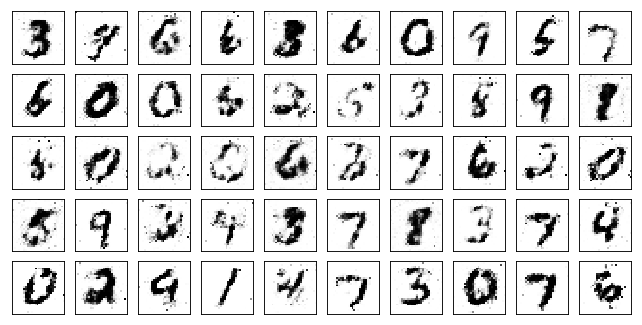

Test losses. G: 2.4790, D: 0.2566
Train Epoch: 61 [0/50000 (0%)]	Losses G: 2.5310, D: 0.3432
Train Epoch: 61 [25000/50000 (50%)]	Losses G: 2.3358, D: 0.3923
Train Epoch: 61 [50000/50000 (100%)]	Losses G: 2.6635, D: 0.3754


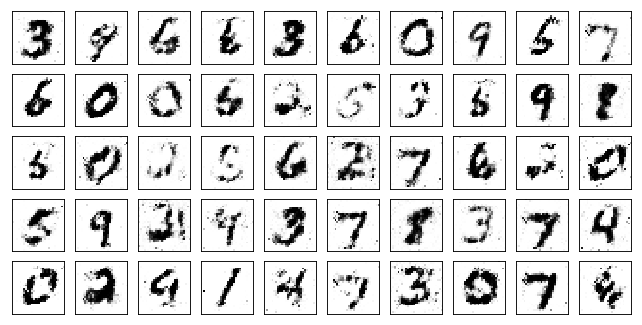

Test losses. G: 2.4022, D: 0.3012
Train Epoch: 62 [0/50000 (0%)]	Losses G: 2.3184, D: 0.3814
Train Epoch: 62 [25000/50000 (50%)]	Losses G: 2.4386, D: 0.4855
Train Epoch: 62 [50000/50000 (100%)]	Losses G: 2.5513, D: 0.3779


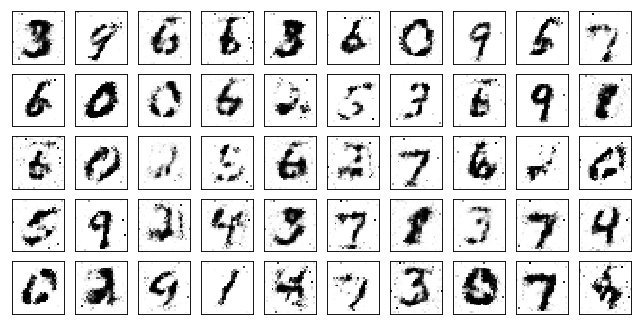

Test losses. G: 2.3217, D: 0.2885
Train Epoch: 63 [0/50000 (0%)]	Losses G: 2.6983, D: 0.3516
Train Epoch: 63 [25000/50000 (50%)]	Losses G: 2.5653, D: 0.4543
Train Epoch: 63 [50000/50000 (100%)]	Losses G: 3.2181, D: 0.2752


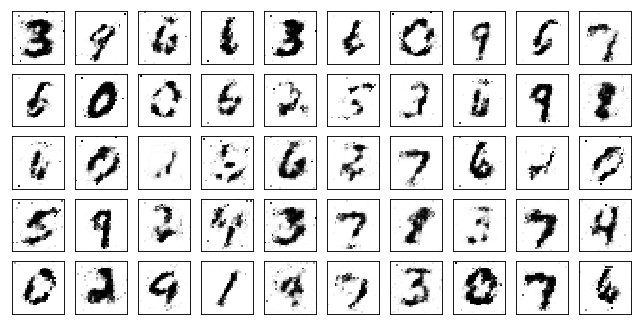

Test losses. G: 2.9086, D: 0.2642
Train Epoch: 64 [0/50000 (0%)]	Losses G: 3.2563, D: 0.3153
Train Epoch: 64 [25000/50000 (50%)]	Losses G: 2.8016, D: 0.3477
Train Epoch: 64 [50000/50000 (100%)]	Losses G: 2.2588, D: 0.3872


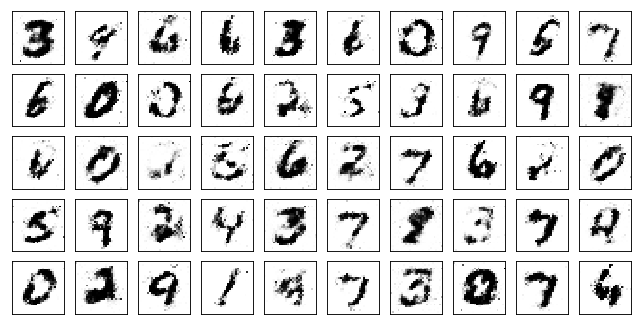

Test losses. G: 2.1857, D: 0.3417
Train Epoch: 65 [0/50000 (0%)]	Losses G: 2.2974, D: 0.3936
Train Epoch: 65 [25000/50000 (50%)]	Losses G: 2.2560, D: 0.3999
Train Epoch: 65 [50000/50000 (100%)]	Losses G: 2.7511, D: 0.3798


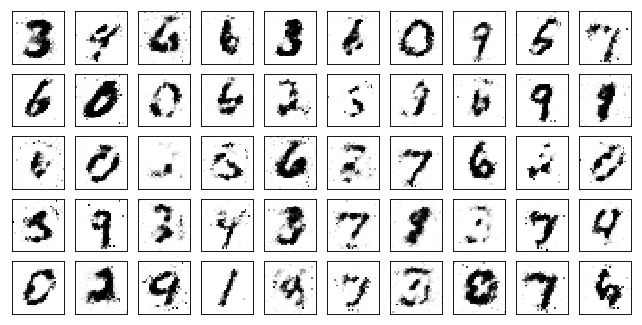

Test losses. G: 2.6217, D: 0.3155
Train Epoch: 66 [0/50000 (0%)]	Losses G: 3.0202, D: 0.2973
Train Epoch: 66 [25000/50000 (50%)]	Losses G: 2.8078, D: 0.2862
Train Epoch: 66 [50000/50000 (100%)]	Losses G: 2.6065, D: 0.3943


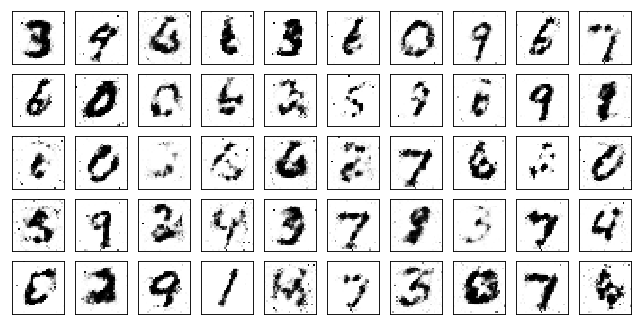

Test losses. G: 2.5002, D: 0.2930
Train Epoch: 67 [0/50000 (0%)]	Losses G: 2.3022, D: 0.4017
Train Epoch: 67 [25000/50000 (50%)]	Losses G: 2.3780, D: 0.3328
Train Epoch: 67 [50000/50000 (100%)]	Losses G: 2.5711, D: 0.4024


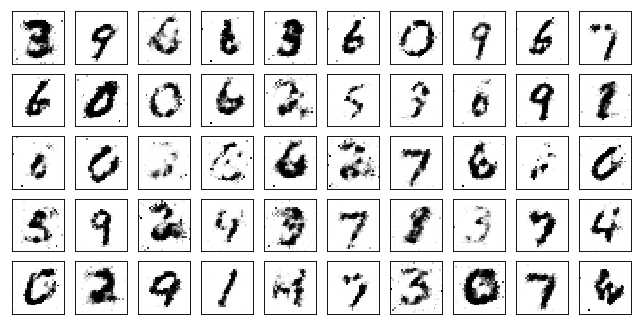

Test losses. G: 2.3558, D: 0.3462
Train Epoch: 68 [0/50000 (0%)]	Losses G: 2.1391, D: 0.4430
Train Epoch: 68 [25000/50000 (50%)]	Losses G: 2.1900, D: 0.4304
Train Epoch: 68 [50000/50000 (100%)]	Losses G: 2.5260, D: 0.3661


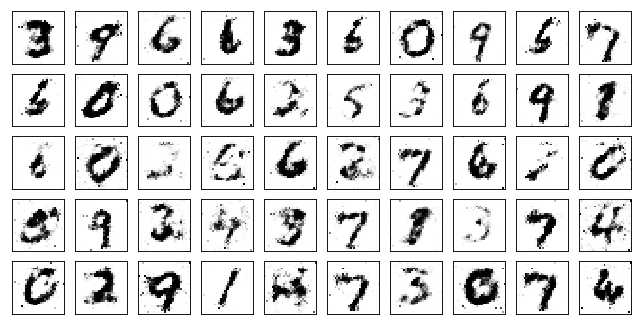

Test losses. G: 2.3891, D: 0.2984
Train Epoch: 69 [0/50000 (0%)]	Losses G: 2.5856, D: 0.3491
Train Epoch: 69 [25000/50000 (50%)]	Losses G: 2.0885, D: 0.3284
Train Epoch: 69 [50000/50000 (100%)]	Losses G: 2.5367, D: 0.4377


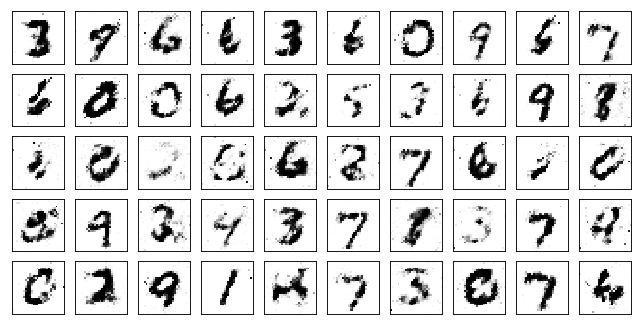

Test losses. G: 2.4834, D: 0.3245
Train Epoch: 70 [0/50000 (0%)]	Losses G: 1.9054, D: 0.4488
Train Epoch: 70 [25000/50000 (50%)]	Losses G: 2.4365, D: 0.3424
Train Epoch: 70 [50000/50000 (100%)]	Losses G: 3.2204, D: 0.3512


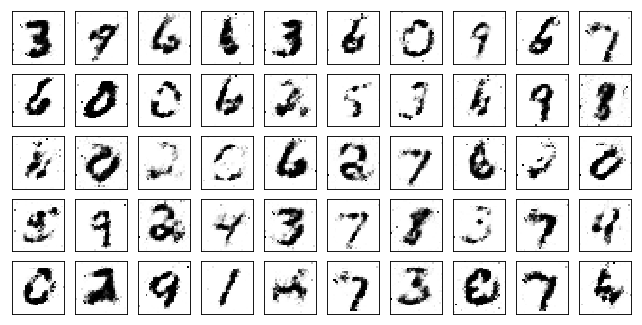

Test losses. G: 2.9852, D: 0.3468
Train Epoch: 71 [0/50000 (0%)]	Losses G: 2.5392, D: 0.5604
Train Epoch: 71 [25000/50000 (50%)]	Losses G: 2.6274, D: 0.3617
Train Epoch: 71 [50000/50000 (100%)]	Losses G: 1.8752, D: 0.4273


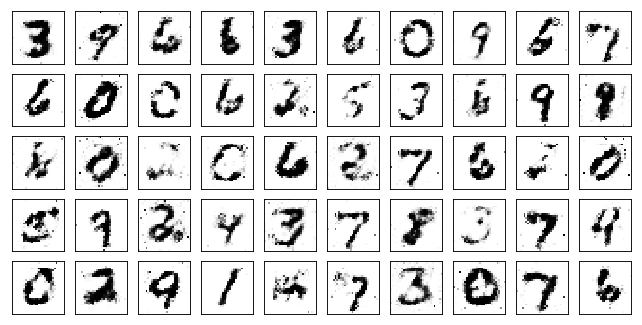

Test losses. G: 1.7593, D: 0.3655
Train Epoch: 72 [0/50000 (0%)]	Losses G: 1.6079, D: 0.4827
Train Epoch: 72 [25000/50000 (50%)]	Losses G: 2.2109, D: 0.4000
Train Epoch: 72 [50000/50000 (100%)]	Losses G: 1.8987, D: 0.5264


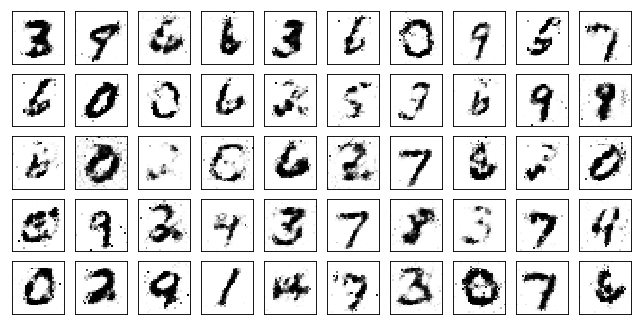

Test losses. G: 1.8253, D: 0.4361
Train Epoch: 73 [0/50000 (0%)]	Losses G: 1.9457, D: 0.4769
Train Epoch: 73 [25000/50000 (50%)]	Losses G: 2.3228, D: 0.4031
Train Epoch: 73 [50000/50000 (100%)]	Losses G: 2.1332, D: 0.5110


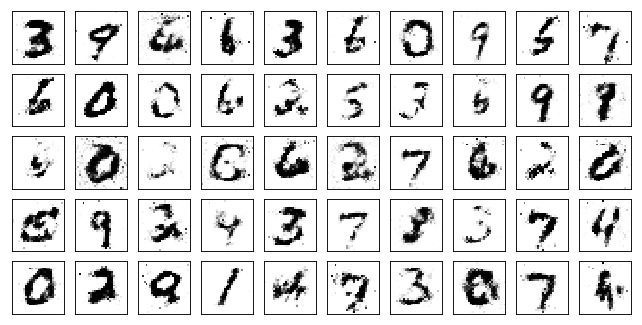

Test losses. G: 2.0664, D: 0.3528
Train Epoch: 74 [0/50000 (0%)]	Losses G: 2.0990, D: 0.4184
Train Epoch: 74 [25000/50000 (50%)]	Losses G: 1.8401, D: 0.4340
Train Epoch: 74 [50000/50000 (100%)]	Losses G: 2.1102, D: 0.4144


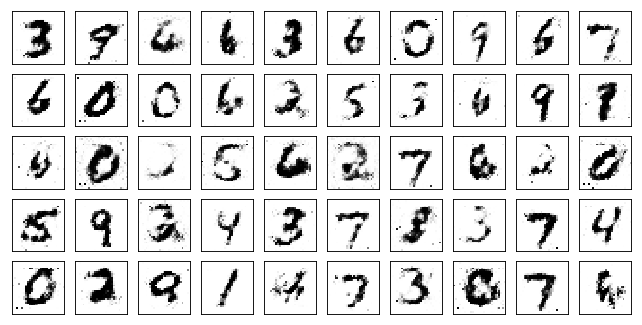

Test losses. G: 2.1140, D: 0.3795
Train Epoch: 75 [0/50000 (0%)]	Losses G: 2.2406, D: 0.3842
Train Epoch: 75 [25000/50000 (50%)]	Losses G: 2.1827, D: 0.4175
Train Epoch: 75 [50000/50000 (100%)]	Losses G: 2.3884, D: 0.3511


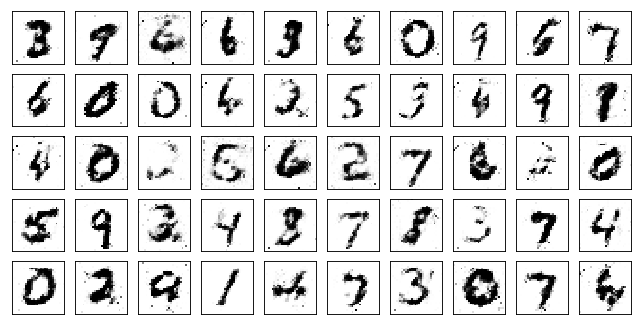

Test losses. G: 2.1306, D: 0.3200
Train Epoch: 76 [0/50000 (0%)]	Losses G: 2.2713, D: 0.4516
Train Epoch: 76 [25000/50000 (50%)]	Losses G: 2.8176, D: 0.3650
Train Epoch: 76 [50000/50000 (100%)]	Losses G: 2.1117, D: 0.3626


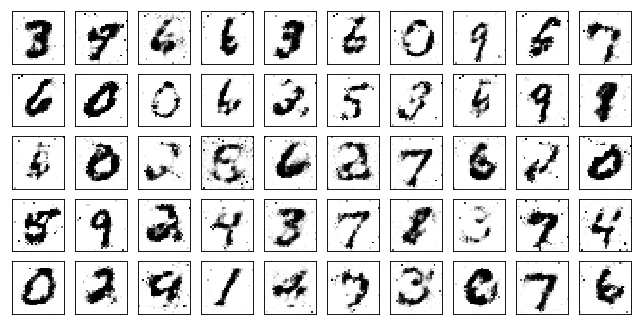

Test losses. G: 2.1454, D: 0.3072
Train Epoch: 77 [0/50000 (0%)]	Losses G: 2.2200, D: 0.3109
Train Epoch: 77 [25000/50000 (50%)]	Losses G: 2.4827, D: 0.4078
Train Epoch: 77 [50000/50000 (100%)]	Losses G: 1.8681, D: 0.5252


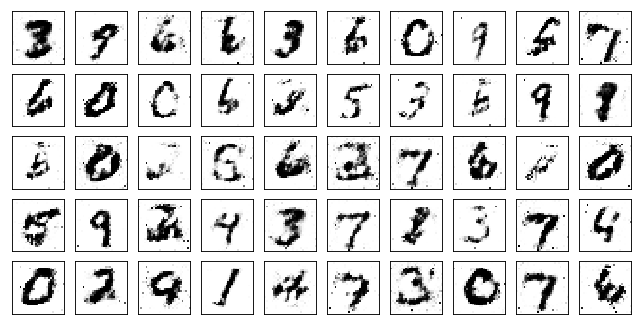

Test losses. G: 1.9750, D: 0.4641
Train Epoch: 78 [0/50000 (0%)]	Losses G: 1.9742, D: 0.5736
Train Epoch: 78 [25000/50000 (50%)]	Losses G: 2.0662, D: 0.3085
Train Epoch: 78 [50000/50000 (100%)]	Losses G: 2.5491, D: 0.3672


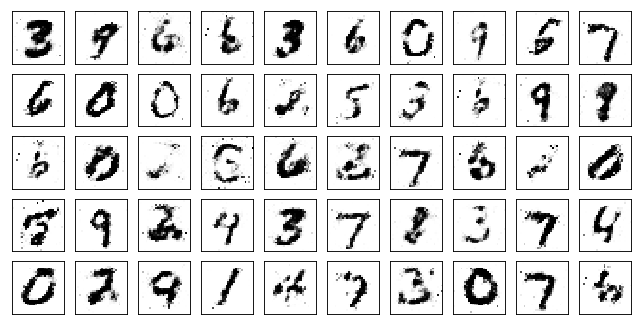

Test losses. G: 2.4865, D: 0.3009
Train Epoch: 79 [0/50000 (0%)]	Losses G: 2.3916, D: 0.3192
Train Epoch: 79 [25000/50000 (50%)]	Losses G: 2.0411, D: 0.3634
Train Epoch: 79 [50000/50000 (100%)]	Losses G: 1.9002, D: 0.4293


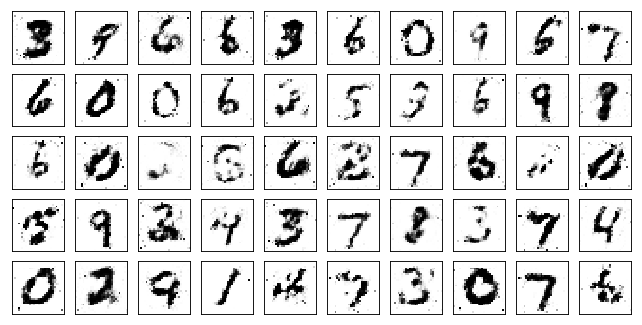

Test losses. G: 1.8707, D: 0.3446
Train Epoch: 80 [0/50000 (0%)]	Losses G: 1.8540, D: 0.4131
Train Epoch: 80 [25000/50000 (50%)]	Losses G: 2.5578, D: 0.4000
Train Epoch: 80 [50000/50000 (100%)]	Losses G: 1.8818, D: 0.5387


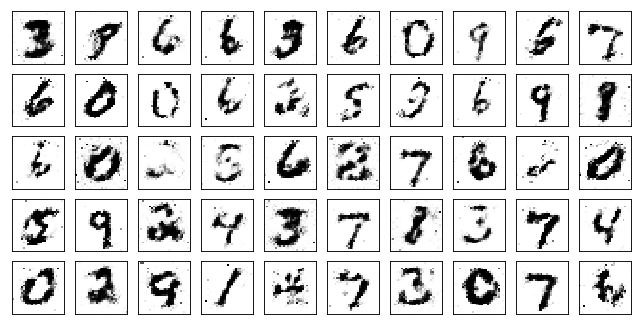

Test losses. G: 1.8690, D: 0.4032
Train Epoch: 81 [0/50000 (0%)]	Losses G: 1.8195, D: 0.4750
Train Epoch: 81 [25000/50000 (50%)]	Losses G: 1.8607, D: 0.4670
Train Epoch: 81 [50000/50000 (100%)]	Losses G: 1.9189, D: 0.4625


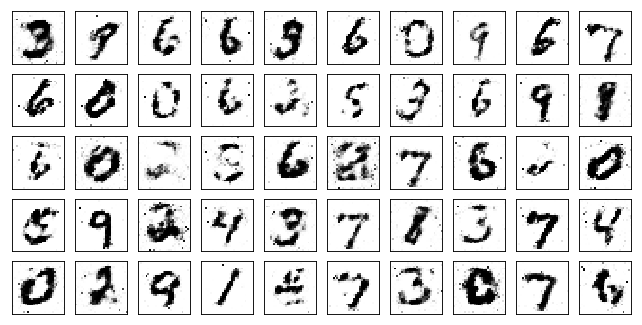

Test losses. G: 1.8212, D: 0.4111
Train Epoch: 82 [0/50000 (0%)]	Losses G: 1.9989, D: 0.4661
Train Epoch: 82 [25000/50000 (50%)]	Losses G: 2.0233, D: 0.4085
Train Epoch: 82 [50000/50000 (100%)]	Losses G: 2.2425, D: 0.3946


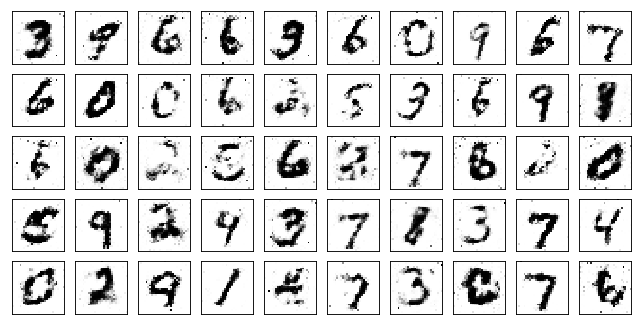

Test losses. G: 2.1795, D: 0.3126
Train Epoch: 83 [0/50000 (0%)]	Losses G: 2.4013, D: 0.3522
Train Epoch: 83 [25000/50000 (50%)]	Losses G: 2.0041, D: 0.4656
Train Epoch: 83 [50000/50000 (100%)]	Losses G: 1.8417, D: 0.5245


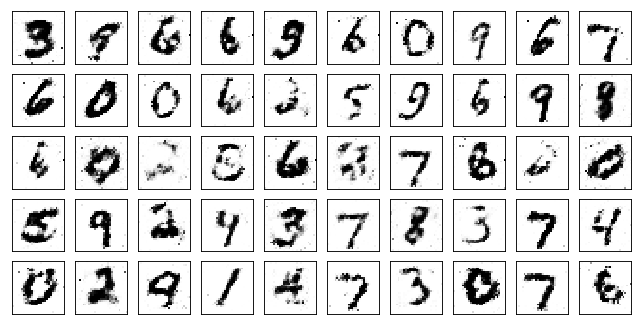

Test losses. G: 1.6892, D: 0.4252
Train Epoch: 84 [0/50000 (0%)]	Losses G: 2.0319, D: 0.5052
Train Epoch: 84 [25000/50000 (50%)]	Losses G: 1.7157, D: 0.4876
Train Epoch: 84 [50000/50000 (100%)]	Losses G: 2.2564, D: 0.4648


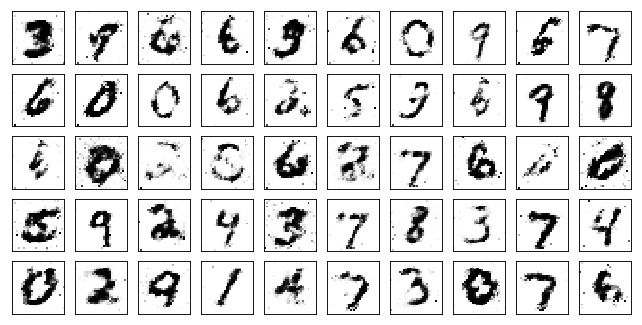

Test losses. G: 2.3836, D: 0.3764
Train Epoch: 85 [0/50000 (0%)]	Losses G: 2.0914, D: 0.4453
Train Epoch: 85 [25000/50000 (50%)]	Losses G: 2.4651, D: 0.3996
Train Epoch: 85 [50000/50000 (100%)]	Losses G: 1.9829, D: 0.5262


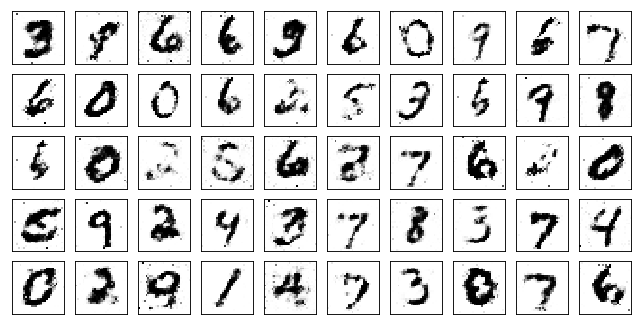

Test losses. G: 1.8605, D: 0.5049
Train Epoch: 86 [0/50000 (0%)]	Losses G: 1.5524, D: 0.5985
Train Epoch: 86 [25000/50000 (50%)]	Losses G: 1.5160, D: 0.5394
Train Epoch: 86 [50000/50000 (100%)]	Losses G: 1.8157, D: 0.4748


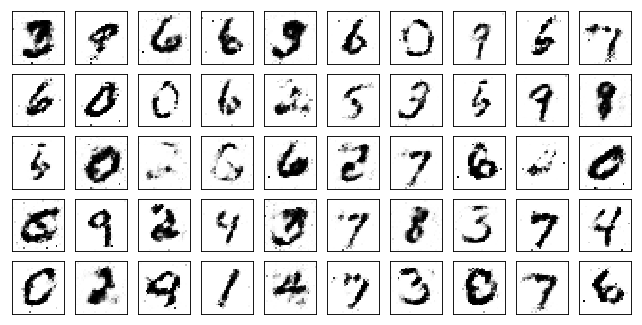

Test losses. G: 1.7176, D: 0.4022
Train Epoch: 87 [0/50000 (0%)]	Losses G: 1.6559, D: 0.4825
Train Epoch: 87 [25000/50000 (50%)]	Losses G: 2.1702, D: 0.4241
Train Epoch: 87 [50000/50000 (100%)]	Losses G: 1.9259, D: 0.4817


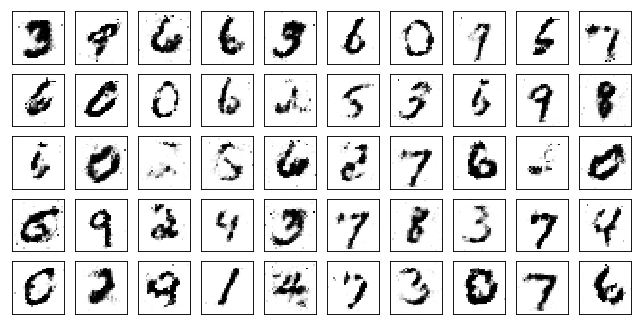

Test losses. G: 1.6780, D: 0.4246
Train Epoch: 88 [0/50000 (0%)]	Losses G: 1.6757, D: 0.4775
Train Epoch: 88 [25000/50000 (50%)]	Losses G: 2.1025, D: 0.4313
Train Epoch: 88 [50000/50000 (100%)]	Losses G: 1.9316, D: 0.4873


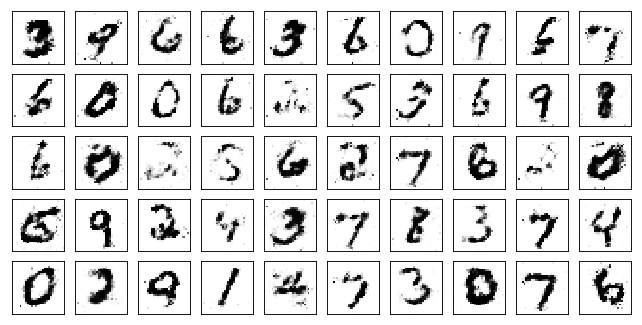

Test losses. G: 1.7812, D: 0.4235
Train Epoch: 89 [0/50000 (0%)]	Losses G: 1.7270, D: 0.4975
Train Epoch: 89 [25000/50000 (50%)]	Losses G: 1.8318, D: 0.5357
Train Epoch: 89 [50000/50000 (100%)]	Losses G: 1.7105, D: 0.4340


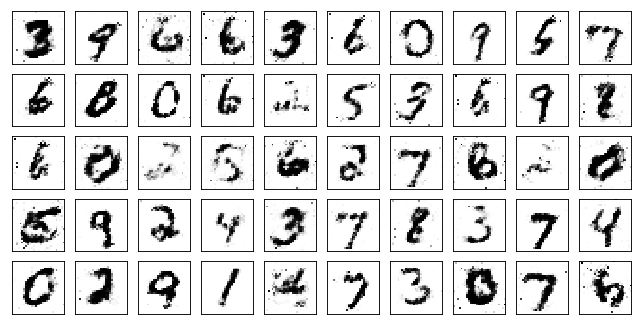

Test losses. G: 1.8248, D: 0.3789
Train Epoch: 90 [0/50000 (0%)]	Losses G: 1.9480, D: 0.4255
Train Epoch: 90 [25000/50000 (50%)]	Losses G: 1.9242, D: 0.4275
Train Epoch: 90 [50000/50000 (100%)]	Losses G: 1.7695, D: 0.4757


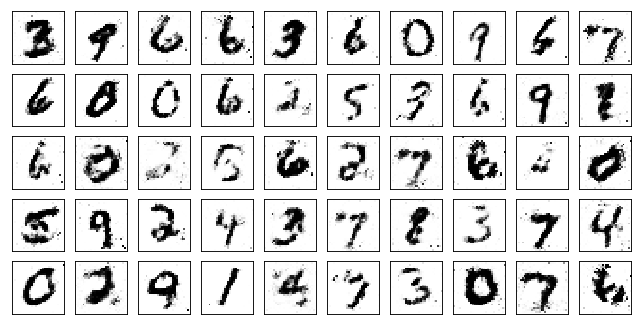

Test losses. G: 1.6791, D: 0.4322
Train Epoch: 91 [0/50000 (0%)]	Losses G: 1.7515, D: 0.4704
Train Epoch: 91 [25000/50000 (50%)]	Losses G: 1.9896, D: 0.4503
Train Epoch: 91 [50000/50000 (100%)]	Losses G: 1.6875, D: 0.5265


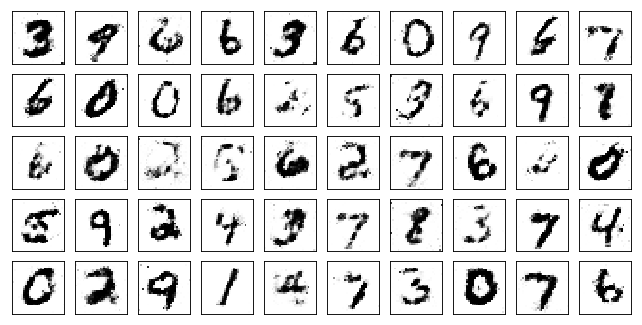

Test losses. G: 1.7192, D: 0.4392
Train Epoch: 92 [0/50000 (0%)]	Losses G: 1.6505, D: 0.5234
Train Epoch: 92 [25000/50000 (50%)]	Losses G: 1.7149, D: 0.4409
Train Epoch: 92 [50000/50000 (100%)]	Losses G: 2.1748, D: 0.4476


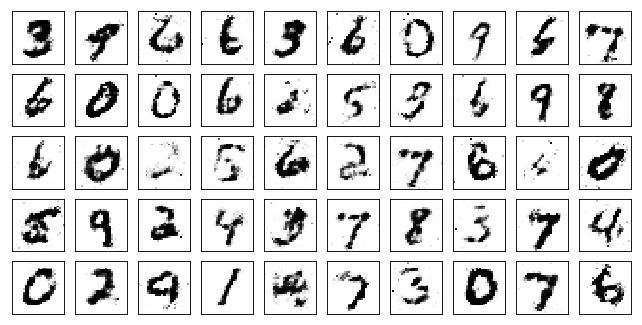

Test losses. G: 1.9097, D: 0.4673
Train Epoch: 93 [0/50000 (0%)]	Losses G: 2.0001, D: 0.5626
Train Epoch: 93 [25000/50000 (50%)]	Losses G: 1.5369, D: 0.4501
Train Epoch: 93 [50000/50000 (100%)]	Losses G: 1.7834, D: 0.4982


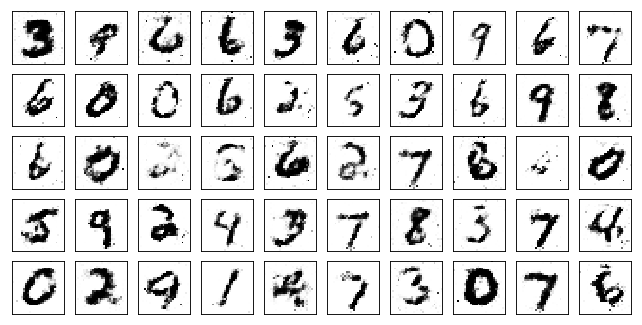

Test losses. G: 1.8499, D: 0.4244
Train Epoch: 94 [0/50000 (0%)]	Losses G: 1.7240, D: 0.4227
Train Epoch: 94 [25000/50000 (50%)]	Losses G: 1.9895, D: 0.4114
Train Epoch: 94 [50000/50000 (100%)]	Losses G: 1.9768, D: 0.4617


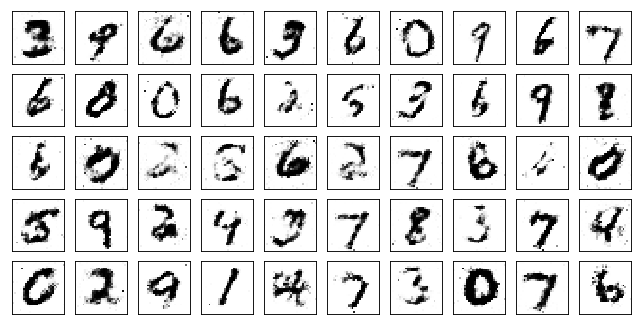

Test losses. G: 1.7578, D: 0.3765
Train Epoch: 95 [0/50000 (0%)]	Losses G: 1.8426, D: 0.4085
Train Epoch: 95 [25000/50000 (50%)]	Losses G: 1.5648, D: 0.5923
Train Epoch: 95 [50000/50000 (100%)]	Losses G: 1.5283, D: 0.5329


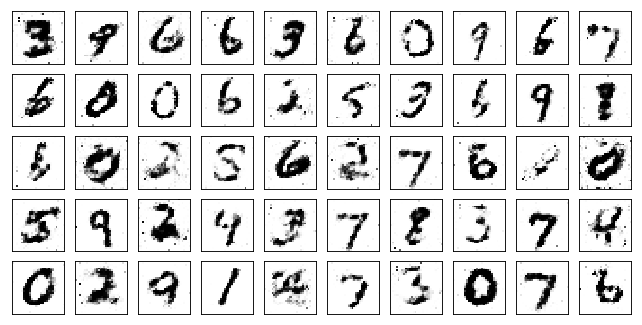

Test losses. G: 1.5380, D: 0.4449
Train Epoch: 96 [0/50000 (0%)]	Losses G: 1.5953, D: 0.4929
Train Epoch: 96 [25000/50000 (50%)]	Losses G: 1.8833, D: 0.4507
Train Epoch: 96 [50000/50000 (100%)]	Losses G: 1.8257, D: 0.4525


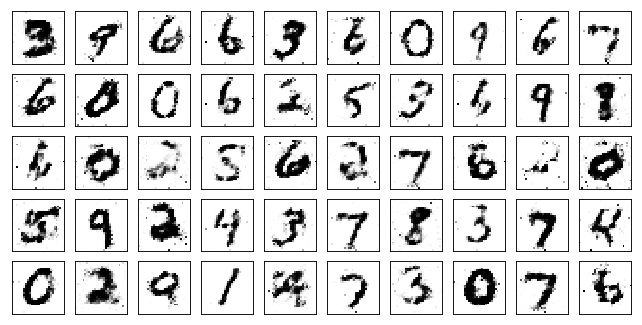

Test losses. G: 1.8472, D: 0.3490
Train Epoch: 97 [0/50000 (0%)]	Losses G: 1.8349, D: 0.3434
Train Epoch: 97 [25000/50000 (50%)]	Losses G: 1.9785, D: 0.5216
Train Epoch: 97 [50000/50000 (100%)]	Losses G: 1.7075, D: 0.5072


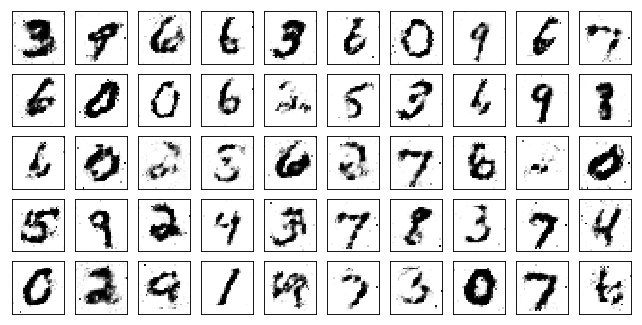

Test losses. G: 1.6899, D: 0.4667
Train Epoch: 98 [0/50000 (0%)]	Losses G: 1.4709, D: 0.6147
Train Epoch: 98 [25000/50000 (50%)]	Losses G: 1.8835, D: 0.4823
Train Epoch: 98 [50000/50000 (100%)]	Losses G: 1.8597, D: 0.4121


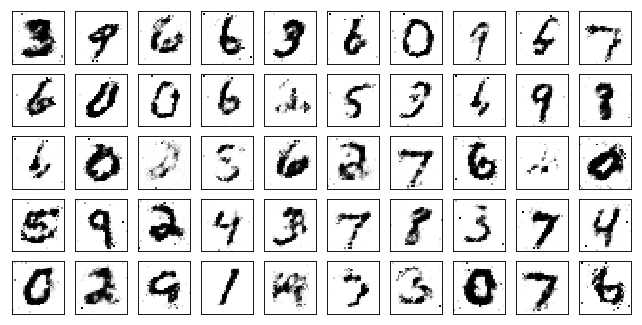

Test losses. G: 1.7689, D: 0.4096
Train Epoch: 99 [0/50000 (0%)]	Losses G: 1.9731, D: 0.4739
Train Epoch: 99 [25000/50000 (50%)]	Losses G: 1.4659, D: 0.6165
Train Epoch: 99 [50000/50000 (100%)]	Losses G: 1.4582, D: 0.5166


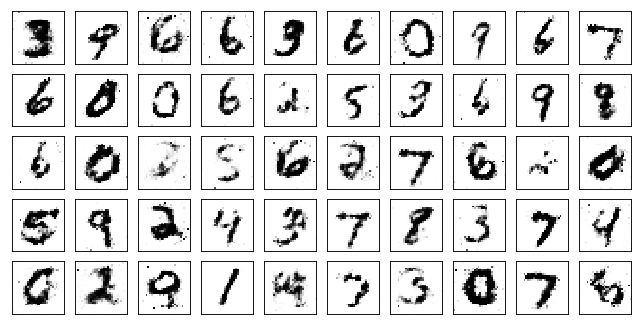

Test losses. G: 1.4110, D: 0.4661
Train Epoch: 100 [0/50000 (0%)]	Losses G: 1.4479, D: 0.5253
Train Epoch: 100 [25000/50000 (50%)]	Losses G: 1.9962, D: 0.3933
Train Epoch: 100 [50000/50000 (100%)]	Losses G: 1.5607, D: 0.4598


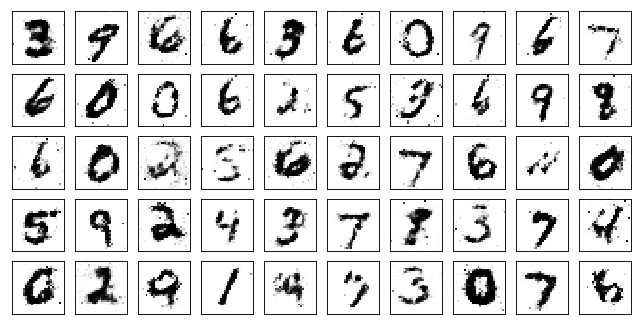

Test losses. G: 1.6285, D: 0.4107


In [20]:
for epoch in range(1, 101):
    G.train()
    D.train()
    train(epoch, G, D, train_log)
    G.eval()
    D.eval()
    test(G, D, valid_loader, epoch, test_log)

In [14]:
fixed_target.view(5, -1)

tensor([[3, 9, 6, 6, 3, 6, 0, 9, 6, 7],
        [6, 0, 0, 6, 2, 5, 3, 6, 9, 8],
        [6, 0, 2, 5, 6, 2, 7, 6, 2, 0],
        [5, 9, 2, 4, 3, 7, 8, 3, 7, 4],
        [0, 2, 9, 1, 4, 7, 3, 0, 7, 6]])

После 100 эпох обучения цифры практически различимы, и совпадают с контрольными. На графиках ошибок видно, как быстро обучается дискриминатор, но постепенно генератору удается все лучше его "обманывать".

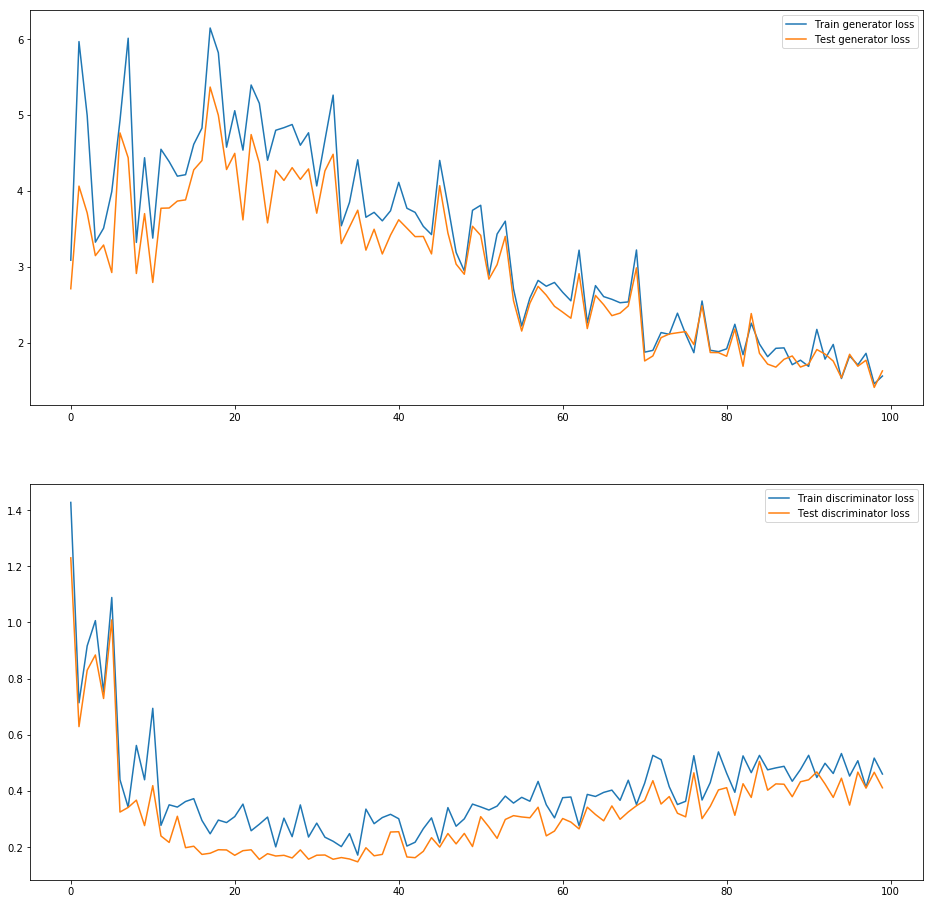

In [21]:
plt.figure(figsize=(16, 16))
plt.subplot(2, 1, 1)
plt.plot(train_log["G"], label="Train generator loss")
plt.plot(test_log["G"], label="Test generator loss")
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(train_log["D"], label="Train discriminator loss")
plt.plot(test_log["D"], label="Test discriminator loss")
plt.legend()
plt.show()

Отображение контрольной выборки меток при трех случайных векторах скрытого пространства. Видно, что в нем содержится информация о стиле написания цифр.

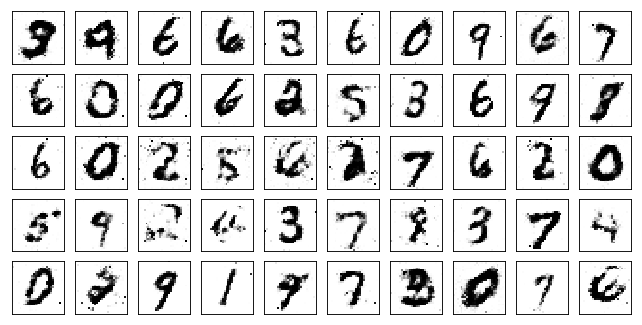

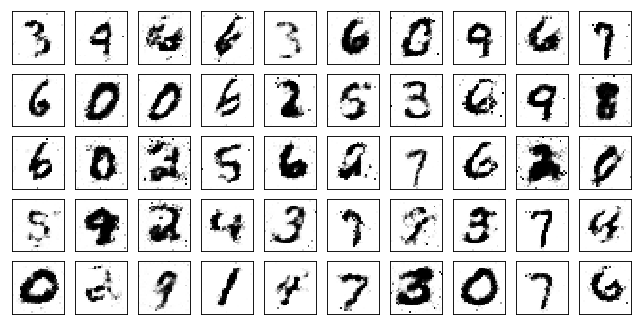

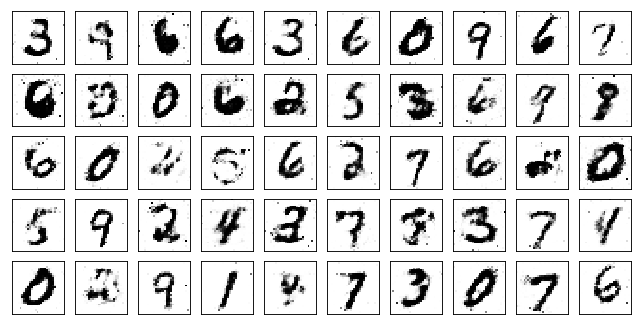

In [25]:
for i in range(3):
    fixed_gen = G(torch.randn((50, 100)).to(device), fixed_target.to(device)).cpu().data.numpy().reshape(50, 1, 28, 28)
    plot_mnist(fixed_gen, (5, 10), True)